Boulle et al. Near-Symmetry Experiment
Singular value range: [1.0, 50.0]
Condition number: 50.0
Primary singular values to perturb: [50.         45.2418709  40.93653765 37.04091103 33.5160023  30.32653299]...
Base matrix: 50×50 full rank
Actual condition number: 50.0
Matrix is symmetric and well-conditioned
Testing columns: [0, 2, 4, 7] (corresponding to σ = [50.         40.93653765 33.5160023  24.82926519])
Perturbation angles θ: [0.005 0.01  0.02  0.03  0.05  0.08  0.1   0.15 ]
Number of test points: 8 × 4 = 32

IMPORTANT: Same θ → Same δ = 1 - cos(θ)
Question: Does same δ affect different singular vectors differently?

==================== Column 0 (σ = 50.0) ====================

Theta = 0.005
    δ computed = 0.000000, δ theory = 0.000012
  δ = 1 - σ_min(U^T V) = 0.000000
  Condition number = 50.0
    Training on matrix with condition number: 50.0
      Epoch 0, Loss: 5.15e-03
      Epoch 100, Loss: 2.29e-03
      Epoch 200, Loss: 9.98e-04
      Epoch 300, Loss: 3.78e-04
      Epo

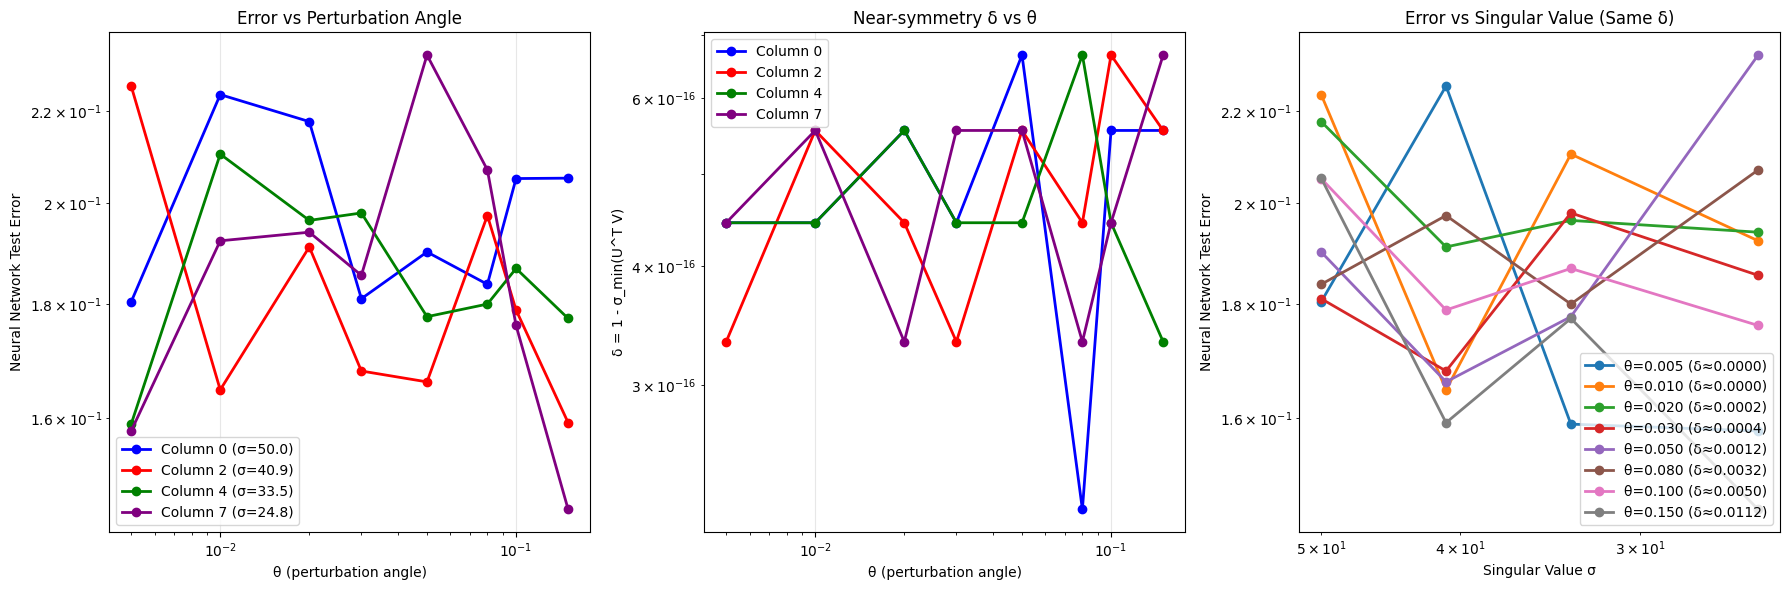


EXPERIMENTAL ANALYSIS:
Theoretical δ values for given θ:
  θ = 0.005 → δ ≈ 0.000012
  θ = 0.010 → δ ≈ 0.000050
  θ = 0.020 → δ ≈ 0.000200
  θ = 0.030 → δ ≈ 0.000450
  θ = 0.050 → δ ≈ 0.001250
  θ = 0.080 → δ ≈ 0.003198
  θ = 0.100 → δ ≈ 0.004996
  θ = 0.150 → δ ≈ 0.011229

Results by column (same δ, different singular vector):

θ = 0.005 (δ ≈ 0.000012):
  Column 0 (σ=50.0): error = 1.80e-01, δ = 0.000000
  Column 2 (σ=40.9): error = 2.26e-01, δ = 0.000000
  Column 4 (σ=33.5): error = 1.59e-01, δ = 0.000000
  Column 7 (σ=24.8): error = 1.58e-01, δ = 0.000000

θ = 0.010 (δ ≈ 0.000050):
  Column 0 (σ=50.0): error = 2.24e-01, δ = 0.000000
  Column 2 (σ=40.9): error = 1.65e-01, δ = 0.000000
  Column 4 (σ=33.5): error = 2.10e-01, δ = 0.000000
  Column 7 (σ=24.8): error = 1.92e-01, δ = 0.000000

θ = 0.020 (δ ≈ 0.000200):
  Column 0 (σ=50.0): error = 2.18e-01, δ = 0.000000
  Column 2 (σ=40.9): error = 1.91e-01, δ = 0.000000
  Column 4 (σ=33.5): error = 1.96e-01, δ = 0.000000
  Column 7 (σ=24.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy
from scipy.linalg import solve
import time

# Correct implementation following your original approach and Boulle et al. definition
np.random.seed(42)
torch.manual_seed(42)

n, r = 50, 8  # Slightly larger for finer mesh effects
rng = np.random.default_rng(123)

print("Boulle et al. Near-Symmetry Experiment")
print("="*50)

# 1. Create a well-conditioned FULL RANK matrix with controlled spread
# Strategy: Create full SVD with reasonable singular value spread

# Create full orthogonal matrices U and V (initially the same for symmetry)
U_full, _ = scipy.linalg.qr(rng.standard_normal((n, n)), mode='full')

# Create singular values with moderate spread (condition number ~50)
# Use exponential decay but not too steep
singular_values_full = np.array([50.0 * np.exp(-0.1 * i) for i in range(n)])
# Ensure minimum singular value is reasonable
singular_values_full = np.maximum(singular_values_full, 1.0)

print(f"Singular value range: [{singular_values_full[-1]:.1f}, {singular_values_full[0]:.1f}]")
print(f"Condition number: {singular_values_full[0]/singular_values_full[-1]:.1f}")

# The "primary" singular vectors we'll perturb (first r of them)
primary_indices = list(range(r))
print(f"Primary singular values to perturb: {singular_values_full[primary_indices][:6]}...")

# Base symmetric matrix A = U Σ U^T (full rank, well-conditioned)
Sigma_full = np.diag(singular_values_full)
A_base = U_full @ Sigma_full @ U_full.T

print(f"Base matrix: {n}×{n} full rank")
print(f"Actual condition number: {np.linalg.cond(A_base):.1f}")
print(f"Matrix is symmetric and well-conditioned")

# Test different perturbation angles - finer mesh as you suggested
thetas = np.array([0.005, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.15])  # More points, finer mesh
columns_to_test = [0, 2, 4, 7]  # Test more columns, but within bounds (n=50, so max index 49)

print(f"Testing columns: {columns_to_test} (corresponding to σ = {singular_values_full[columns_to_test]})")
print(f"Perturbation angles θ: {thetas}")
print(f"Number of test points: {len(thetas)} × {len(columns_to_test)} = {len(thetas) * len(columns_to_test)}")
print(f"\nIMPORTANT: Same θ → Same δ = 1 - cos(θ)")
print(f"Question: Does same δ affect different singular vectors differently?")

# Simple neural network
class InverseNet(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 80),
            nn.ReLU(),
            nn.Linear(80, 60),
            nn.ReLU(),
            nn.Linear(60, n)
        )
        # Xavier initialization
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_normal_(layer.weight)
                torch.nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        return self.net(x)

def build_perturbed_matrix_correct(U_full, Sigma_full, col_idx, theta, rng):
    """
    Build perturbed matrix: Start with A = U Σ U^T, create A = U Σ V^T
    where V has col_idx-th column perturbed by angle theta
    """
    n = U_full.shape[0]
    
    # Create V by perturbing the col_idx-th column of U_full
    V_full = U_full.copy()
    
    # Generate random direction orthogonal to the col_idx-th column
    z = rng.standard_normal(n)
    # Make z orthogonal to the col_idx-th column
    u_col = U_full[:, col_idx]
    z = z - np.dot(z, u_col) * u_col
    z_norm = np.linalg.norm(z)
    
    if z_norm < 1e-12:  # Handle degenerate case
        print(f"    Warning: degenerate perturbation for θ={theta}")
        return None, None
    
    z = z / z_norm
    
    # Rotate the col_idx-th column by angle theta
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    V_full[:, col_idx] = cos_theta * U_full[:, col_idx] + sin_theta * z
    
    # Re-orthonormalize V_full (could use Gram-Schmidt or QR)
    V_full, _ = scipy.linalg.qr(V_full, mode='full')
    
    # Build the perturbed matrix A = U Σ V^T
    A_perturbed = U_full @ Sigma_full @ V_full.T
    
    # Compute δ = 1 - σ_min(U^T V) as per Boulle et al.
    UV = U_full.T @ V_full
    try:
        sigma_min_UV = np.linalg.svd(UV, compute_uv=False)[-1]
        delta = 1 - sigma_min_UV
        
        # Theoretical prediction: δ ≈ 1 - cos(θ)
        delta_theory = 1 - np.cos(theta)
        print(f"    δ computed = {delta:.6f}, δ theory = {delta_theory:.6f}")
        
    except:
        print(f"    SVD failed for θ={theta}")
        return None, None
    
    return A_perturbed, delta

def train_inverse_operator(A_matrix, n_train=400, n_epochs=600):
    """Train neural network to learn A^{-1} with improved stability"""
    
    # Check conditioning - should be reasonable now
    cond_num = np.linalg.cond(A_matrix)
    if cond_num > 1e3:  # Stricter threshold since we control conditioning
        print(f"    Matrix condition number higher than expected: {cond_num:.1f}")
        if cond_num > 1e6:
            return np.nan
    
    print(f"    Training on matrix with condition number: {cond_num:.1f}")
    
    # Generate training data with better scaling
    X_train = rng.standard_normal((n_train, n)) * 0.1  # RHS vectors (smaller scale)
    Y_train = np.zeros_like(X_train)  # Solutions
    
    # Solve A*u = f for each training sample
    valid_samples = 0
    for i in range(n_train):
        try:
            Y_train[i] = solve(A_matrix, X_train[i])
            if np.isfinite(Y_train[i]).all():
                valid_samples += 1
            else:
                Y_train[i] = 0
        except:
            Y_train[i] = 0
    
    if valid_samples < n_train * 0.8:  # Expect high success rate
        print(f"    Too few valid samples: {valid_samples}/{n_train}")
        return np.nan
    
    # Convert to tensors
    X_tensor = torch.FloatTensor(X_train)
    Y_tensor = torch.FloatTensor(Y_train)
    
    # Create and train model
    model = InverseNet(n)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)  # Smaller learning rate
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50)
    
    best_loss = float('inf')
    model.train()
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        pred = model(X_tensor)
        loss = torch.mean((pred - Y_tensor)**2)
        
        if not torch.isfinite(loss):
            print(f"    Non-finite loss at epoch {epoch}")
            return np.nan
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        scheduler.step(loss)
        
        current_loss = loss.item()
        if current_loss < best_loss:
            best_loss = current_loss
        
        # Early stopping with better criteria
        if epoch % 100 == 0:
            print(f"      Epoch {epoch}, Loss: {current_loss:.2e}")
            if epoch > 200 and current_loss < 1e-6:
                print(f"      Early stopping: converged")
                break
    
    # Test on fresh data
    n_test = 100
    X_test = rng.standard_normal((n_test, n)) * 0.1
    Y_test_true = np.array([solve(A_matrix, x) for x in X_test])
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        Y_test_pred = model(X_test_tensor).numpy()
    
    # Compute test error (relative MSE)
    test_error = np.mean((Y_test_pred - Y_test_true)**2)
    relative_error = test_error / np.mean(Y_test_true**2)
    
    print(f"    Final test error: {relative_error:.2e}")
    return relative_error

# Main experiment loop
results = {}
all_deltas = {}

for col_idx in columns_to_test:
    print(f"\n{'='*20} Column {col_idx} (σ = {singular_values_full[col_idx]:.1f}) {'='*20}")
    
    results[col_idx] = []
    all_deltas[col_idx] = []
    
    for i, theta in enumerate(thetas):
        print(f"\nTheta = {theta:.3f}")
        
        # Build perturbed matrix
        A_pert, delta = build_perturbed_matrix_correct(U_full, Sigma_full, col_idx, theta, rng)
        
        if A_pert is None:
            print("    Skipping due to degeneracy")
            results[col_idx].append(np.nan)
            all_deltas[col_idx].append(np.nan)
            continue
        
        print(f"  δ = 1 - σ_min(U^T V) = {delta:.6f}")
        print(f"  Condition number = {np.linalg.cond(A_pert):.1f}")
        
        # Train neural network with more robust setup
        start_time = time.time()
        test_error = train_inverse_operator(A_pert, n_train=300, n_epochs=500)
        train_time = time.time() - start_time
        
        print(f"  Test error = {test_error:.2e}")
        print(f"  Training time = {train_time:.1f}s")
        
        results[col_idx].append(test_error)
        all_deltas[col_idx].append(delta)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['blue', 'red', 'green', 'purple', 'orange']

# Plot 1: Error vs theta for each column
ax1 = axes[0]
for i, col_idx in enumerate(columns_to_test):
    valid_indices = [j for j, err in enumerate(results[col_idx]) if np.isfinite(err)]
    if valid_indices:
        valid_thetas = [thetas[j] for j in valid_indices]
        valid_errors = [results[col_idx][j] for j in valid_indices]
        
        ax1.loglog(valid_thetas, valid_errors, 'o-', color=colors[i], 
                   label=f'Column {col_idx} (σ={singular_values_full[col_idx]:.1f})', 
                   linewidth=2, markersize=6)

ax1.set_xlabel('θ (perturbation angle)')
ax1.set_ylabel('Neural Network Test Error')
ax1.set_title('Error vs Perturbation Angle')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Delta vs theta (should be similar curves)
ax2 = axes[1]
for i, col_idx in enumerate(columns_to_test):
    valid_indices = [j for j, delta in enumerate(all_deltas[col_idx]) if np.isfinite(delta)]
    if valid_indices:
        valid_thetas = [thetas[j] for j in valid_indices]
        valid_deltas = [all_deltas[col_idx][j] for j in valid_indices]
        
        ax2.loglog(valid_thetas, valid_deltas, 'o-', color=colors[i], 
                   label=f'Column {col_idx}', linewidth=2, markersize=6)

ax2.set_xlabel('θ (perturbation angle)')
ax2.set_ylabel('δ = 1 - σ_min(U^T V)')
ax2.set_title('Near-symmetry δ vs θ')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Error vs singular value (for same δ) - THE REAL QUESTION!
ax3 = axes[2]

# Plot error vs singular value for each theta value
for i, theta in enumerate(thetas):
    errors_this_theta = []
    sigma_values = []
    
    for col_idx in columns_to_test:
        if i < len(results[col_idx]) and np.isfinite(results[col_idx][i]):
            errors_this_theta.append(results[col_idx][i])
            sigma_values.append(singular_values_full[col_idx])
    
    if len(errors_this_theta) > 1:
        delta_val = 1 - np.cos(theta)
        ax3.loglog(sigma_values, errors_this_theta, 'o-', 
                   label=f'θ={theta:.3f} (δ≈{delta_val:.4f})', 
                   linewidth=2, markersize=6)

ax3.set_xlabel('Singular Value σ')
ax3.set_ylabel('Neural Network Test Error')
ax3.set_title('Error vs Singular Value (Same δ)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.invert_xaxis()  # Larger singular values on left

plt.tight_layout()
plt.show()

# Analysis and Summary
print("\n" + "="*60)
print("EXPERIMENTAL ANALYSIS:")
print("="*60)

print(f"Theoretical δ values for given θ:")
for theta in thetas:
    delta_theory = 1 - np.cos(theta)
    print(f"  θ = {theta:.3f} → δ ≈ {delta_theory:.6f}")

print(f"\nResults by column (same δ, different singular vector):")

# Organize results by theta (since delta should be the same)
for i, theta in enumerate(thetas):
    print(f"\nθ = {theta:.3f} (δ ≈ {1-np.cos(theta):.6f}):")
    
    for col_idx in columns_to_test:
        if i < len(results[col_idx]) and np.isfinite(results[col_idx][i]):
            error = results[col_idx][i]
            delta = all_deltas[col_idx][i] if i < len(all_deltas[col_idx]) else np.nan
            print(f"  Column {col_idx} (σ={singular_values_full[col_idx]:.1f}): "
                  f"error = {error:.2e}, δ = {delta:.6f}")

print(f"\nKEY QUESTION: For the same δ, do different singular vectors show different errors?")

# Check if there's a pattern with singular value magnitude
for i, theta in enumerate(thetas):
    errors_this_theta = []
    sigma_values = []
    
    for col_idx in columns_to_test:
        if i < len(results[col_idx]) and np.isfinite(results[col_idx][i]):
            errors_this_theta.append(results[col_idx][i])
            sigma_values.append(singular_values_full[col_idx])
    
    if len(errors_this_theta) > 1:
        # Check correlation between sigma value and error
        if len(set(errors_this_theta)) > 1:  # Not all errors identical
            corr = np.corrcoef(sigma_values, np.log(errors_this_theta))[0,1]
            print(f"  θ={theta:.3f}: Correlation(σ, log(error)) = {corr:.3f}")

print(f"\nTHEORY TEST:")
print(f"According to Boulle et al., the bound is ||A - AP_n|| ≤ (1/|λ_n+1|) ||LA*||")
print(f"If this depends on which singular vector is perturbed, we should see:")
print(f"- Same δ (same θ) but different errors for different columns")
print(f"- Possibly worse performance when perturbing smaller singular values")

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.linalg
from scipy.linalg import solve
import time

# Much simpler, more controlled experiment
rng = np.random.default_rng(seed = 42)

print("SIMPLIFIED Near-Symmetry Test")
print("="*40)

n, r = 20, 5
thetas = np.linspace(0, 0.3, 8)      # You can densify if you like
n_trials = 5
columns = range(r)

results = {k: [] for k in columns}
deltas = {k: [] for k in columns}

U_A, _ = scipy.linalg.qr(rng.standard_normal((n, r)), mode='economic')
sing_vals_A = np.logspace(-2, 2, r)[::-1]
S_A = np.diag(sing_vals_A)

def matrix_generator(U_A, S_A, theta, col_idx):

    # Prepare z (orthogonal to span(U_A), normed)
    z = rng.standard_normal((U_A.shape[0], 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)
    
    # Perturb the specified column
    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)
    V_A[:, [col_idx]] = c * U_A[:, [col_idx]] + s * z
    V_A, _ = scipy.linalg.qr(V_A, mode="economic")

    matrix = U_A @ S_A @ V_A.T

    sigma_min = np.linalg.svd(U_A.T @ V_A, compute_uv=False)[-1]
    delta = 1 - sigma_min

    return matrix, delta

def compute_asymmetry_measure(A):

    """||A - A^T|| / ||A||"""

    frob_asymmetry = np.linalg.norm(A - A.T, 'fro') / np.linalg.norm(A, 'fro')
    two_asymmetry = np.linalg.norm(A - A.T, 2) / np.linalg.norm(A, 2)

    return frob_asymmetry, two_asymmetry

# Simple network for tiny matrices
class TinyNet(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, n)
        )
    
    def forward(self, x):
        return self.net(x)

def test_matrix_learning(A_matrix, matrix_name, delta, n_trials=5):
    """Test how well neural networks can learn A^{-1} for given matrix"""
    
    print(f"\n--- Testing {matrix_name} ---")
    cond_num = np.linalg.cond(A_matrix)
    #_, delta = matrix_generator(A_matrix)
    asym_measure, _ = compute_asymmetry_measure(A_matrix)
    
    print(f"Condition number: {cond_num:.2f}")
    print(f"δ (Boulle): {delta:.6f}")
    print(f"Asymmetry ||A-A^T||/||A||: {asym_measure:.6f}")
    
    # Multiple trials to reduce noise
    errors = []
    
    for trial in range(n_trials):
        torch.manual_seed(42 + trial)
        np.random.seed(42 + trial)
        
        # Generate training data
        n_train = 200
        X_train = rng.standard_normal((n_train, A_matrix.shape[0])) * 0.5
        Y_train = np.array([solve(A_matrix, x) for x in X_train])
        
        # Convert to tensors
        X_tensor = torch.FloatTensor(X_train)
        Y_tensor = torch.FloatTensor(Y_train)
        
        # Train network
        model = TinyNet(A_matrix.shape[0])
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        
        # Training loop
        for epoch in range(1000):
            optimizer.zero_grad()
            pred = model(X_tensor)
            loss = torch.mean((pred - Y_tensor)**2)
            loss.backward()
            optimizer.step()
            
            if epoch % 200 == 0:
                pass  # Silent training
        
        # Test
        X_test = rng.standard_normal((50, A_matrix.shape[0])) * 0.5
        Y_test_true = np.array([solve(A_matrix, x) for x in X_test])
        
        model.eval()
        with torch.no_grad():
            Y_test_pred = model(torch.FloatTensor(X_test)).numpy()
        
        # Compute relative error
        rel_error = np.mean((Y_test_pred - Y_test_true)**2) / np.mean(Y_test_true**2)
        errors.append(rel_error)
    
    avg_error = np.mean(errors)
    std_error = np.std(errors)
    
    print(f"Average test error: {avg_error:.2e} ± {std_error:.2e}")
    
    return {
        'name': matrix_name,
        'condition_number': cond_num,
        'delta_boulle': delta,
        'asymmetry_measure': asym_measure,
        'avg_error': avg_error,
        'std_error': std_error,
        'errors': errors
    }

for col_idx in columns:
    print(f"\n======== Perturbing column {col_idx} ========")
    for theta in thetas:
        # Generate Boullé-style matrix for each theta and column
        A, delta = matrix_generator(U_A, S_A, theta, col_idx)
        # Run the neural network and record avg error
        result = test_matrix_learning(A, f"Boulle_col{col_idx}_theta{theta:.2f}", delta, n_trials=n_trials)
        results[col_idx].append(result['avg_error'])
        deltas[col_idx].append(delta)

# Plotting: One line for each column perturbed
plt.figure(figsize=(10,6))
for col_idx in columns:
    plt.plot(thetas, results[col_idx], label=f'Column {col_idx}')
plt.xlabel(r'$\theta$')
plt.ylabel('Neural Net Test Error')
plt.title('Test Error vs Theta for Each Column Perturbed (Boullé)')
plt.legend(title="Perturbed Singular Vector")
plt.yscale('log')
plt.tight_layout()
plt.show()

# Optional: plot delta vs theta for each column
plt.figure(figsize=(10,5))
for col_idx in columns:
    plt.plot(thetas, deltas[col_idx], label=f'Col {col_idx}')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\delta$')
plt.title('Delta vs Theta for Each Column Perturbed')
plt.legend()
plt.tight_layout()
plt.show()

# Analysis
print("\n" + "="*60)
print("RESULTS SUMMARY:")
print("="*60)

print(f"{'Name':<15} {'Cond':<8} {'δ':<10} {'Asym':<10} {'Error':<12} {'Std':<10}")
print("-" * 65)

for r in results:
    print(f"{r['name']:<15} {r['condition_number']:<8.1f} {r['delta_boulle']:<10.6f} "
          f"{r['asymmetry_measure']:<10.6f} {r['avg_error']:<12.2e} {r['std_error']:<10.2e}")

# Simple visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Error vs δ
deltas = [r['delta_boulle'] for r in results]
errors = [r['avg_error'] for r in results]
error_bars = [r['std_error'] for r in results]
names = [r['name'] for r in results]

ax1.errorbar(deltas, errors, yerr=error_bars, fmt='o', capsize=5, markersize=8)
for i, name in enumerate(names):
    ax1.annotate(name, (deltas[i], errors[i]), xytext=(5, 5), textcoords='offset points')

ax1.set_xlabel('δ (Near-symmetry measure)')
ax1.set_ylabel('Neural Network Test Error')
ax1.set_title('Error vs δ (Simplified Test)')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Error vs asymmetry measure
asym_measures = [r['asymmetry_measure'] for r in results]

ax2.errorbar(asym_measures, errors, yerr=error_bars, fmt='s', capsize=5, markersize=8, color='red')
for i, name in enumerate(names):
    ax2.annotate(name, (asym_measures[i], errors[i]), xytext=(5, 5), textcoords='offset points')

ax2.set_xlabel('||A - A^T|| / ||A|| (Asymmetry)')
ax2.set_ylabel('Neural Network Test Error')
ax2.set_title('Error vs Asymmetry Measure')
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# Statistical analysis
print(f"\nSTATISTICAL ANALYSIS:")
if len(results) > 2:
    # Correlation analysis
    deltas_arr = np.array(deltas)
    errors_arr = np.array(errors)
    asym_arr = np.array(asym_measures)
    
    if np.std(deltas_arr) > 0:
        corr_delta = np.corrcoef(deltas_arr, np.log(errors_arr))[0, 1]
        print(f"Correlation(δ, log(error)): {corr_delta:.3f}")
    
    if np.std(asym_arr) > 0:
        corr_asym = np.corrcoef(asym_arr, np.log(errors_arr))[0, 1]
        print(f"Correlation(asymmetry, log(error)): {corr_asym:.3f}")
    
    # Check if trend is clear
    if len(results) == 3:
        if errors[0] < errors[1] < errors[2]:
            print("✓ Clear increasing trend: symmetric < slight_asym < more_asym")
        elif errors[0] > errors[1] > errors[2]:
            print("✗ Decreasing trend (opposite of theory)")
        else:
            print("? No clear monotonic trend")

print(f"\nTEST SUMMARY:")
print(f"This simplified test uses tiny, well-controlled matrices to check")
print(f"if the basic phenomenon exists: do neural networks struggle more")
print(f"with less symmetric matrices?")

# Alternative direct test using matrix powers
print(f"\n" + "="*60)
print("DIRECT SPECTRAL TEST (Alternative approach):")
print("="*60)

def spectral_analysis(A, name):
    """Analyze spectral properties that might affect learning"""
    eigenvals = np.linalg.eigvals(A)
    
    # Measure spectral asymmetry
    spectral_radius = max(abs(eigenvals))
    real_parts = eigenvals.real
    imag_parts = eigenvals.imag
    
    max_imaginary = max(abs(imag_parts))
    spectral_asym = max_imaginary / spectral_radius
    
    print(f"{name}: Spectral asymmetry = {spectral_asym:.6f}")
    return spectral_asym

for name, A in matrices.items():
    spectral_analysis(A, name)

SIMPLIFIED Near-Symmetry Test

======== Perturbing column 0 ========

--- Testing Boulle_col0_theta0.00 ---
Condition number: 30438144308038160384.00
δ (Boulle): 0.000000
Asymmetry ||A-A^T||/||A||: 0.000000


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=2.31665e-20): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.31665e-20): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 1.06e-14

--- Testing Boulle_col0_theta0.04 ---
Condition number: 2420883645319331328.00
δ (Boulle): 0.000918
Asymmetry ||A-A^T||/||A||: 0.060287


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=2.48373e-19): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.48373e-19): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 3.32e-13

--- Testing Boulle_col0_theta0.09 ---
Condition number: 36339437359965970432.00
δ (Boulle): 0.003671
Asymmetry ||A-A^T||/||A||: 0.120463


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=6.3923e-20): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.3923e-20): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 5.96e-14

--- Testing Boulle_col0_theta0.13 ---
Condition number: 7993889092358285312.00
δ (Boulle): 0.008254
Asymmetry ||A-A^T||/||A||: 0.180418


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=1.10131e-19): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.10131e-19): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 8.11e-14

--- Testing Boulle_col0_theta0.17 ---
Condition number: 1622845016757974784.00
δ (Boulle): 0.014658
Asymmetry ||A-A^T||/||A||: 0.240042


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=1.66081e-19): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.66081e-19): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 9.15e-14

--- Testing Boulle_col0_theta0.21 ---
Condition number: 33819798751032025088.00
δ (Boulle): 0.022871
Asymmetry ||A-A^T||/||A||: 0.299224


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=3.197e-19): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.197e-19): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 2.24e-13

--- Testing Boulle_col0_theta0.26 ---
Condition number: 10638769403588061184.00
δ (Boulle): 0.032879
Asymmetry ||A-A^T||/||A||: 0.357858


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=1.48346e-20): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.48346e-20): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 1.02e-14

--- Testing Boulle_col0_theta0.30 ---
Condition number: 886217308019104000.00
δ (Boulle): 0.044664
Asymmetry ||A-A^T||/||A||: 0.415834


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=6.17399e-20): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.17399e-20): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 1.01e-13

======== Perturbing column 1 ========

--- Testing Boulle_col1_theta0.00 ---
Condition number: 30438144308038160384.00
δ (Boulle): 0.000000
Asymmetry ||A-A^T||/||A||: 0.000000
Average test error: 1.00e+00 ± 3.66e-14

--- Testing Boulle_col1_theta0.04 ---
Condition number: 4472150471462475264.00
δ (Boulle): 0.000918
Asymmetry ||A-A^T||/||A||: 0.006029


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=1.36034e-19): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.36034e-19): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 8.25e-14

--- Testing Boulle_col1_theta0.09 ---
Condition number: 1401357275593084160.00
δ (Boulle): 0.003671
Asymmetry ||A-A^T||/||A||: 0.012046


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=2.79396e-19): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.79396e-19): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 1.18e-13

--- Testing Boulle_col1_theta0.13 ---
Condition number: 985516326233899904.00
δ (Boulle): 0.008254
Asymmetry ||A-A^T||/||A||: 0.018042


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=2.17226e-19): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.17226e-19): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 1.03e-13

--- Testing Boulle_col1_theta0.17 ---
Condition number: 18587134314195316736.00
δ (Boulle): 0.014658
Asymmetry ||A-A^T||/||A||: 0.024004


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=1.91186e-19): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.91186e-19): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 2.85e-13

--- Testing Boulle_col1_theta0.21 ---
Condition number: 5707828600285293568.00
δ (Boulle): 0.022871
Asymmetry ||A-A^T||/||A||: 0.029922


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=1.1063e-20): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.1063e-20): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 1.19e-14

--- Testing Boulle_col1_theta0.26 ---
Condition number: 1020437826338314368.00
δ (Boulle): 0.032879
Asymmetry ||A-A^T||/||A||: 0.035786


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=3.5729e-19): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.5729e-19): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 1.63e-13

--- Testing Boulle_col1_theta0.30 ---
Condition number: 4666627159650424832.00
δ (Boulle): 0.044664
Asymmetry ||A-A^T||/||A||: 0.041583


C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:94: LinAlgWarning: Ill-conditioned matrix (rcond=1.92424e-19): result may not be accurate.
  Y_train = np.array([solve(A_matrix, x) for x in X_train])
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\2231987248.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.92424e-19): result may not be accurate.
  Y_test_true = np.array([solve(A_matrix, x) for x in X_test])


Average test error: 1.00e+00 ± 1.51e-13

======== Perturbing column 2 ========

--- Testing Boulle_col2_theta0.00 ---
Condition number: 30438144308038160384.00
δ (Boulle): 0.000000
Asymmetry ||A-A^T||/||A||: 0.000000
Average test error: 1.00e+00 ± 2.62e-14

--- Testing Boulle_col2_theta0.04 ---
Condition number: 21069017511758663680.00
δ (Boulle): 0.000918
Asymmetry ||A-A^T||/||A||: 0.000603


LinAlgError: Matrix is singular.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.linalg
from scipy.linalg import solve

# Config
n = 12
thetas = np.linspace(0, 0.4, 10)  # more points for smoother curve
columns = range(n)
n_trials = 3

rng = np.random.default_rng(42)

# Generate a SINGLE U_A, and S_A for all runs (for meaningful "closeness")
U_A, _ = np.linalg.qr(rng.standard_normal((n, n)))
sing_vals = np.linspace(3, 30, n)   # All positive, well-conditioned (edit as needed)
S_A = np.diag(sing_vals)
def matrix_generator(U_A, S_A, theta, col_idx, rng):
    n, r = U_A.shape
    # Copy U_A
    V_A = U_A.copy()
    # Make a vector orthogonal to all of U_A
    z = rng.standard_normal((n, 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)
    # Mix in z into the col_idx-th column
    c, s = np.cos(theta), np.sin(theta)
    V_A[:, [col_idx]] = c * U_A[:, [col_idx]] + s * z
    # Orthonormalize
    V_A, _ = np.linalg.qr(V_A)
    # Construct matrix
    A = U_A @ S_A @ V_A.T
    # Boulle delta
    sigma_min = np.linalg.svd(U_A.T @ V_A, compute_uv=False)[-1]
    delta = 1 - sigma_min
    return A, delta

def compute_asymmetry_measure(A):
    frob_asym = np.linalg.norm(A - A.T, 'fro') / np.linalg.norm(A, 'fro')
    return frob_asym

class TinyNet(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 24), nn.ReLU(),
            nn.Linear(24, 24), nn.ReLU(),
            nn.Linear(24, n)
        )
    def forward(self, x): return self.net(x)

def test_matrix_learning(A, matrix_name, delta, n_trials=3):
    print(f"\n--- Testing {matrix_name} ---")
    cond_num = np.linalg.cond(A)
    asym_measure = compute_asymmetry_measure(A)
    print(f"Condition #: {cond_num:.2f}  δ={delta:.6f}  ||A-Aᵗ||/||A||={asym_measure:.5f}")
    errors = []
    for trial in range(n_trials):
        torch.manual_seed(1 + trial)
        np.random.seed(1 + trial)
        X_train = np.random.randn(200, A.shape[0]) * 0.5
        Y_train = np.array([solve(A, x) for x in X_train])
        X_tensor = torch.FloatTensor(X_train)
        Y_tensor = torch.FloatTensor(Y_train)
        model = TinyNet(A.shape[0])
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        for epoch in range(800):  # (reduce epochs for speed)
            optimizer.zero_grad()
            pred = model(X_tensor)
            loss = torch.mean((pred - Y_tensor)**2)
            loss.backward()
            optimizer.step()
        # Test
        X_test = np.random.randn(40, A.shape[0]) * 0.5
        Y_test = np.array([solve(A, x) for x in X_test])
        model.eval()
        with torch.no_grad():
            Y_pred = model(torch.FloatTensor(X_test)).numpy()
        rel_error = np.mean((Y_pred - Y_test)**2) / np.mean(Y_test**2)
        errors.append(rel_error)
    avg_error = np.mean(errors)
    print(f"Avg test error: {avg_error:.3e}")
    return delta, asym_measure, avg_error

# Experiment
results = {col: {"thetas": [], "deltas": [], "errors": []} for col in columns}
for col_idx in columns:
    print(f"\n========= Perturbing column {col_idx} =========")
    for theta in thetas:
        A, delta = matrix_generator(U_A, S_A, theta, col_idx, rng)
        _, _, err = test_matrix_learning(A, f"col{col_idx}_theta{theta:.2f}", delta, n_trials=n_trials)
        results[col_idx]["thetas"].append(theta)
        results[col_idx]["deltas"].append(delta)
        results[col_idx]["errors"].append(err)

# Plot: For each column, error vs theta and error vs delta
plt.figure(figsize=(12, 6))
for col_idx in columns:
    plt.plot(results[col_idx]["thetas"], results[col_idx]["errors"], label=f'Col {col_idx}')
plt.xlabel(r'$\theta$')
plt.ylabel('Neural Net Test Error')
plt.title('Test Error vs Theta (each singular vector perturbed)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for col_idx in columns:
    plt.plot(results[col_idx]["deltas"], results[col_idx]["errors"], 'o-', label=f'Col {col_idx}')
plt.xlabel(r'$\delta$')
plt.ylabel('Neural Net Test Error')
plt.title('Test Error vs Boullé $\delta$ (each singular vector perturbed)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()


<>:116: SyntaxWarning: invalid escape sequence '\d'
<>:116: SyntaxWarning: invalid escape sequence '\d'
C:\Users\aleks\AppData\Local\Temp\ipykernel_43256\1036437230.py:116: SyntaxWarning: invalid escape sequence '\d'
  plt.title('Test Error vs Boullé $\delta$ (each singular vector perturbed)')



========= Perturbing column 0 =========

--- Testing col0_theta0.00 ---
Condition #: 10.00  δ=0.000000  ||A-Aᵗ||/||A||=0.00000


KeyboardInterrupt: 


========= Perturbing column 0 =========

--- col0_theta0.00 ---
δ=0.000000   RelTestErr=4.183e-02

--- col0_theta0.00 ---
δ=0.000000   RelTestErr=4.259e-02

--- col0_theta0.00 ---
δ=0.000001   RelTestErr=4.212e-02

--- col0_theta0.00 ---
δ=0.000001   RelTestErr=4.240e-02

--- col0_theta0.00 ---
δ=0.000002   RelTestErr=4.278e-02

--- col0_theta0.00 ---
δ=0.000004   RelTestErr=4.272e-02

--- col0_theta0.00 ---
δ=0.000005   RelTestErr=4.226e-02

--- col0_theta0.00 ---
δ=0.000007   RelTestErr=4.188e-02

--- col0_theta0.00 ---
δ=0.000009   RelTestErr=4.263e-02

--- col0_theta0.00 ---
δ=0.000011   RelTestErr=4.214e-02

--- col0_theta0.01 ---
δ=0.000014   RelTestErr=4.263e-02

--- col0_theta0.01 ---
δ=0.000017   RelTestErr=4.193e-02

--- col0_theta0.01 ---
δ=0.000020   RelTestErr=4.383e-02

--- col0_theta0.01 ---
δ=0.000024   RelTestErr=4.136e-02

--- col0_theta0.01 ---
δ=0.000027   RelTestErr=4.197e-02

--- col0_theta0.01 ---
δ=0.000031   RelTestErr=4.264e-02

--- col0_theta0.01 ---
δ=0.000

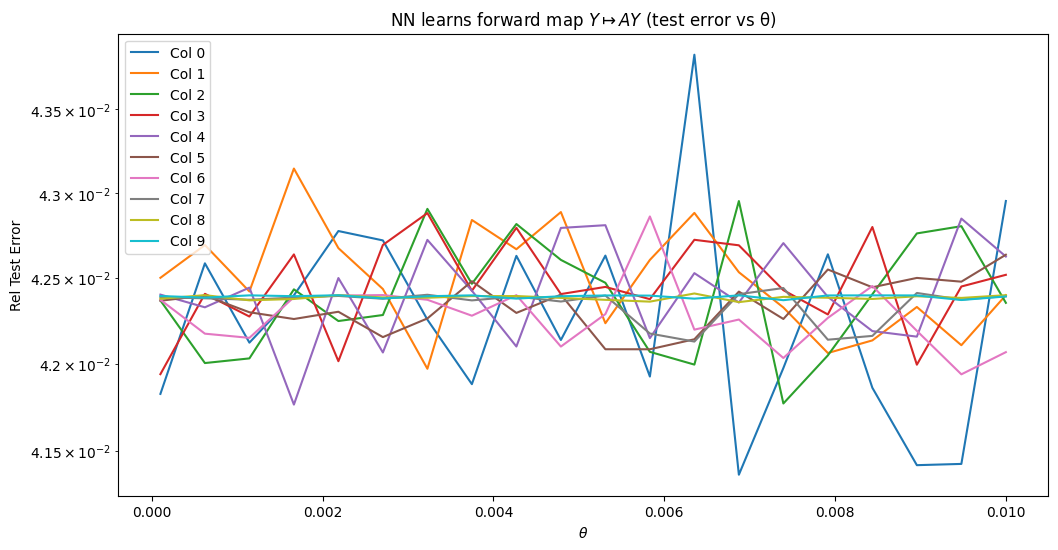

In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

n = 50
r = 10  # Use only r < n columns
thetas = np.linspace(1e-4, 1e-2, 20)
columns = range(r)  # Only test columns 0 to r-1
n_trials = 3

rng = np.random.default_rng(42)

# Generate U_A as n×r (not n×n!)
U_A, _ = np.linalg.qr(rng.standard_normal((n, r)), mode="reduced")  # n×r matrix
sing_vals = np.logspace(-3, 2,r)[::-1]
S_A = np.diag(sing_vals)

def matrix_generator_controlled(U_A, sing_vals_A, theta, col_idx, rng):
    """
    Perturb a specific column by angle theta
    """
    n, r = U_A.shape  # Now r < n
    Sigma = np.diag(sing_vals_A)
    
    # Generate random direction orthogonal to span(U_A)
    z = rng.standard_normal((n, 1))
    z -= U_A @ (U_A.T @ z)  # Now this leaves non-zero z!
    z_norm = np.linalg.norm(z)
    
    if z_norm < 1e-10:
        print("Warning: z became zero!")
        return None, 0
        
    z /= z_norm
    
    # Create V_A by perturbing the specified column
    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)
    V_A[:, [col_idx]] = c * U_A[:, [col_idx]] + s * z
    
    # Re-orthonormalize
    V_A, _ = np.linalg.qr(V_A, mode="reduced")
    
    # Build matrix A = U Σ V^T + regularization for full rank
    A_lowrank = U_A @ Sigma @ V_A.T
    A = A_lowrank + 0.1 * np.eye(n)  # Make full rank
    
    # Compute delta
    sigma_min = np.linalg.svd(U_A.T @ V_A, compute_uv=False)[-1]
    delta = 1 - sigma_min
    
    return A, delta

class ForwardNet(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, n)
        )
    def forward(self, x):
        return self.net(x)

def train_forward_mapping(A, matrix_name, delta, n_trials=3):
    print(f"\n--- {matrix_name} ---")
    errors = []
    for trial in range(n_trials):
        torch.manual_seed(1 + trial)
        np.random.seed(1 + trial)
        # Training data
        Y = np.random.randn(256, n)
        Z = (A @ Y.T).T  # batch
        # Test data
        Y_test = np.random.randn(64, n)
        Z_test = (A @ Y_test.T).T
        # Network
        net = ForwardNet(n)
        opt = optim.Adam(net.parameters(), lr=1e-3)
        Y_t = torch.FloatTensor(Y)
        Z_t = torch.FloatTensor(Z)
        for epoch in range(800):
            opt.zero_grad()
            pred = net(Y_t)
            loss = ((pred - Z_t) ** 2).mean()
            loss.backward()
            opt.step()
        # Test
        net.eval()
        with torch.no_grad():
            pred_test = net(torch.FloatTensor(Y_test)).numpy()
        rel_error = np.mean((pred_test - Z_test) ** 2) / np.mean(Z_test ** 2)
        errors.append(rel_error)
    avg_err = np.mean(errors)
    print(f"δ={delta:.6f}   RelTestErr={avg_err:.3e}")
    return delta, avg_err

results = {col: {"thetas": [], "deltas": [], "errors": []} for col in columns}
for col_idx in columns:
    print(f"\n========= Perturbing column {col_idx} =========")
    for theta in thetas:
        A, delta = matrix_generator_controlled(U_A, sing_vals, theta,col_idx, rng)
        d, err = train_forward_mapping(A, f"col{col_idx}_theta{theta:.2f}", delta, n_trials)
        results[col_idx]["thetas"].append(theta)
        results[col_idx]["deltas"].append(d)
        results[col_idx]["errors"].append(err)

# Plot
plt.figure(figsize=(12, 6))
for col_idx in columns:
    plt.plot(results[col_idx]["thetas"], results[col_idx]["errors"], label=f'Col {col_idx}')
plt.xlabel(r'$\theta$')
plt.ylabel('Rel Test Error')
plt.title('NN learns forward map $Y \\mapsto AY$ (test error vs θ)')
plt.yscale('log')
plt.legend()
plt.show()


Matrix dimensions: 50×50, rank = 10
Pseudoinverse dimensions: 10×50
Condition number in subspace: 100000.0

========= Perturbing column 0 =========

--- col0_theta0.00 ---
δ=0.000000   PseudoInv_Error=5.320e-02

--- col0_theta0.02 ---
δ=0.000125   PseudoInv_Error=5.320e-02

--- col0_theta0.03 ---
δ=0.000499   PseudoInv_Error=5.321e-02

--- col0_theta0.05 ---
δ=0.001122   PseudoInv_Error=5.315e-02

--- col0_theta0.06 ---
δ=0.001994   PseudoInv_Error=5.325e-02

--- col0_theta0.08 ---
δ=0.003115   PseudoInv_Error=5.310e-02

--- col0_theta0.09 ---
δ=0.004484   PseudoInv_Error=5.323e-02

--- col0_theta0.11 ---
δ=0.006102   PseudoInv_Error=5.324e-02

--- col0_theta0.13 ---
δ=0.007967   PseudoInv_Error=5.313e-02

--- col0_theta0.14 ---
δ=0.010080   PseudoInv_Error=5.325e-02

--- col0_theta0.16 ---
δ=0.012439   PseudoInv_Error=5.311e-02

--- col0_theta0.17 ---
δ=0.015045   PseudoInv_Error=5.321e-02

--- col0_theta0.19 ---
δ=0.017897   PseudoInv_Error=5.316e-02

--- col0_theta0.21 ---
δ=0.02099

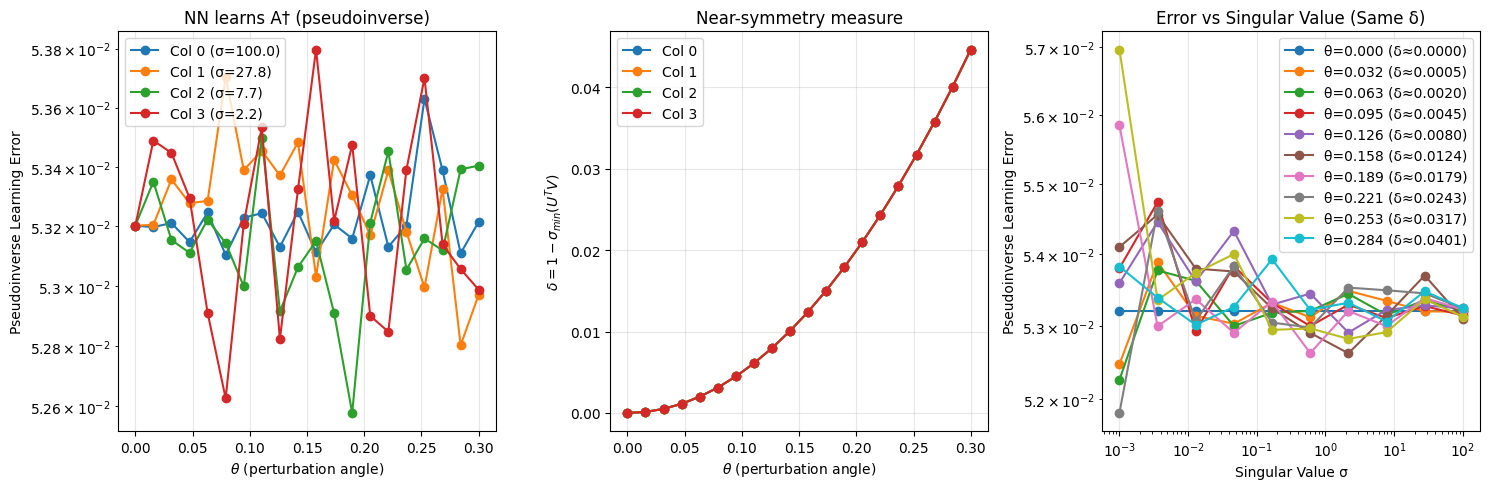


Key insight: Learning pseudoinverse A† instead of forward map
This should reveal the effects predicted by Boulle et al. theory!


In [49]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.linalg import pinv

def matrix_generator_pseudoinverse(U_A, sing_vals_A, theta, col_idx, rng):
    """
    Create rank-deficient matrix and learn its pseudoinverse
    """
    n, r = U_A.shape  # n > r for rank deficiency
    Sigma = np.diag(sing_vals_A)
    
    # Generate random direction orthogonal to span(U_A)
    z = rng.standard_normal((n, 1))
    z -= U_A @ (U_A.T @ z)  # Project out U_A component
    z_norm = np.linalg.norm(z)
    
    if z_norm < 1e-10:
        return None, 0
    z /= z_norm
    
    # Create V_A by perturbing the specified column
    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)
    V_A[:, [col_idx]] = c * U_A[:, [col_idx]] + s * z
    
    # Re-orthonormalize
    V_A, _ = np.linalg.qr(V_A, mode="reduced")
    
    # Build rank-deficient matrix A = U Σ V^T
    A = U_A @ Sigma @ V_A.T  # This is n×n but rank r
    
    # Compute pseudoinverse
    A_pinv = pinv(A)  # r×n matrix
    
    # Compute delta
    sigma_min = np.linalg.svd(U_A.T @ V_A, compute_uv=False)[-1]
    delta = 1 - sigma_min
    
    return A, A_pinv, delta

def train_pseudoinverse_mapping(A, A_pinv, matrix_name, delta, n_trials=3):
    """
    Train NN to learn the pseudoinverse mapping
    """
    print(f"\n--- {matrix_name} ---")
    n, r = A.shape[0], A_pinv.shape[0]
    
    class PseudoInverseNet(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, output_dim)
            )
        
        def forward(self, x):
            return self.net(x)
    
    errors = []
    for trial in range(n_trials):
        torch.manual_seed(1 + trial)
        np.random.seed(1 + trial)
        
        # Training data: Y (n-dim) -> A_pinv @ Y (r-dim)
        Y_train = np.random.randn(256, n)
        X_train = (A_pinv @ Y_train.T).T  # True pseudoinverse output
        
        # Test data
        Y_test = np.random.randn(64, n)
        X_test = (A_pinv @ Y_test.T).T
        
        # Network learns: n-dim input -> r-dim output
        net = PseudoInverseNet(n, r)
        optimizer = optim.Adam(net.parameters(), lr=1e-3)
        
        Y_tensor = torch.FloatTensor(Y_train)
        X_tensor = torch.FloatTensor(X_train)
        
        # Training loop
        for epoch in range(1000):
            optimizer.zero_grad()
            pred = net(Y_tensor)
            loss = torch.mean((pred - X_tensor)**2)
            loss.backward()
            optimizer.step()
        
        # Test
        net.eval()
        with torch.no_grad():
            pred_test = net(torch.FloatTensor(Y_test)).numpy()
        
        # Compute relative error
        rel_error = np.mean((pred_test - X_test)**2) / np.mean(X_test**2)
        errors.append(rel_error)
    
    avg_err = np.mean(errors)
    print(f"δ={delta:.6f}   PseudoInv_Error={avg_err:.3e}")
    return delta, avg_err

# Main experiment
n = 50  # Ambient dimension
r = 10   # Rank (n > r for rank deficiency)
thetas = np.linspace(0, 0.3, 20)
columns = range(r)

rng = np.random.default_rng(42)

# Generate U_A as n×r matrix
U_A, _ = np.linalg.qr(rng.standard_normal((n, r)), mode="reduced")
sing_vals = np.logspace(-3, 2, r)[::-1]  # Well-conditioned within the r-dimensional subspace

print(f"Matrix dimensions: {n}×{n}, rank = {r}")
print(f"Pseudoinverse dimensions: {r}×{n}")
print(f"Condition number in subspace: {sing_vals[0]/sing_vals[-1]:.1f}")

results = {col: {"thetas": [], "deltas": [], "errors": []} for col in columns}

for col_idx in columns:
    print(f"\n========= Perturbing column {col_idx} =========")
    for theta in thetas:
        result = matrix_generator_pseudoinverse(U_A, sing_vals, theta, col_idx, rng)
        
        if result[0] is not None:
            A, A_pinv, delta = result
            d, err = train_pseudoinverse_mapping(A, A_pinv, f"col{col_idx}_theta{theta:.2f}", delta, n_trials=3)
            results[col_idx]["thetas"].append(theta)
            results[col_idx]["deltas"].append(d)
            results[col_idx]["errors"].append(err)
        else:
            print(f"Failed to generate matrix for col={col_idx}, theta={theta}")

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot 1: Error vs theta
plt.subplot(1, 3, 1)
for col_idx in columns[:4]:  # Show subset for clarity
    if results[col_idx]["errors"]:
        plt.plot(results[col_idx]["thetas"], results[col_idx]["errors"], 
                'o-', label=f'Col {col_idx} (σ={sing_vals[col_idx]:.1f})')

plt.xlabel(r'$\theta$ (perturbation angle)')
plt.ylabel('Pseudoinverse Learning Error')
plt.title('NN learns A† (pseudoinverse)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Delta vs theta (should be same for all columns)
plt.subplot(1, 3, 2)
for col_idx in columns[:4]:
    if results[col_idx]["deltas"]:
        plt.plot(results[col_idx]["thetas"], results[col_idx]["deltas"], 
                'o-', label=f'Col {col_idx}')

plt.xlabel(r'$\theta$ (perturbation angle)')
plt.ylabel(r'$\delta = 1 - \sigma_{min}(U^T V)$')
plt.title('Near-symmetry measure')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Error vs singular value (for same delta)
plt.subplot(1, 3, 3)
for i, theta in enumerate(thetas[::2]):  # Every other theta for clarity
    errors_this_theta = []
    sigma_values = []
    
    for col_idx in columns:
        if i < len(results[col_idx]["errors"]):
            errors_this_theta.append(results[col_idx]["errors"][i])
            sigma_values.append(sing_vals[col_idx])
    
    if len(errors_this_theta) > 1:
        delta_val = 1 - np.cos(theta)
        plt.loglog(sigma_values, errors_this_theta, 'o-', 
                  label=f'θ={theta:.3f} (δ≈{delta_val:.4f})')

plt.xlabel('Singular Value σ')
plt.ylabel('Pseudoinverse Learning Error')
plt.title('Error vs Singular Value (Same δ)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey insight: Learning pseudoinverse A† instead of forward map")
print(f"This should reveal the effects predicted by Boulle et al. theory!")

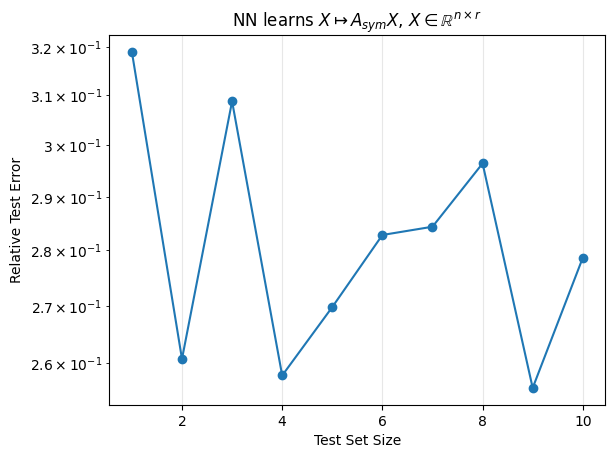


Relative error for test set size 1:   3.19e-01
Relative error for test set size 100: 2.79e-01 (should be near zero for perfect fit)


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

n = 100   # You can change n!
r = 10
n_trials = 3

rng = np.random.default_rng(42)

# Generate U_A as n×r, make orthonormal basis for the symmetric map
U_A, _ = np.linalg.qr(rng.standard_normal((n, r)), mode="reduced")  # n×r
sing_vals = np.logspace(-3, 2, r)[::-1]
Sigma = np.diag(sing_vals)

# Build full symmetric n×n matrix using U_A
# Extend U_A to n×n orthogonal for "full" symmetric, or just use n×r for low-rank
if r < n:
    U_full, _ = np.linalg.qr(rng.standard_normal((n, n)))
else:
    U_full = U_A

# A_sym is symmetric, rank r (could be low-rank)
A_sym = U_A @ Sigma @ U_A.T

class LeftMultiplyNet(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.M = nn.Parameter(torch.randn(n, n))  # Only n x n weights!
    def forward(self, x):
        # x: (batch, n, r)
        return torch.matmul(self.M, x)

def train_forward_mapping(A, n, r, n_trials=3):
    errors_by_testsize = []
    for trial in range(n_trials):
        torch.manual_seed(1 + trial)
        np.random.seed(1 + trial)
        # TRAIN on all basis vectors
        X_train = np.eye(n).reshape(n, n, 1)       # (n, n, 1)
        Z_train = np.matmul(A, X_train)            # (n, n, 1)
        net = LeftMultiplyNet(n)
        opt = optim.Adam(net.parameters(), lr=1e-3)
        X_t = torch.FloatTensor(X_train)
        Z_t = torch.FloatTensor(Z_train)
        for epoch in range(2000):
            opt.zero_grad()
            pred = net(X_t)
            loss = ((pred - Z_t) ** 2).mean()
            loss.backward()
            opt.step()
        # TEST: (as before)
        errs = []
        for test_size in range(1, r+1):
            X_test = np.random.randn(test_size, n, r)
            Z_test = np.matmul(A, X_test)
            net.eval()
            with torch.no_grad():
                pred_test = net(torch.FloatTensor(X_test)).numpy()
            rel_error = np.mean((pred_test - Z_test) ** 2) / np.mean(Z_test ** 2)
            errs.append(rel_error)
        errors_by_testsize.append(errs)
    avg_errs = np.mean(errors_by_testsize, axis=0)
    return avg_errs

def nystrom_approx_function(A, X):

    A_nystrom = (A @ X) @ np.linalg.inv(X.T @ A @ X) @ (A @ X).T

    return A_nystrom

avg_errs = train_forward_mapping(A_sym, n, r, n_trials=3)
plt.plot(range(1, r+1), avg_errs, marker='o')
plt.xlabel('Test Set Size')
plt.ylabel('Relative Test Error')
plt.title(r'NN learns $X \mapsto A_{sym} X$, $X \in \mathbb{R}^{n \times r}$')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

# Print key results for endpoints
print(f"\nRelative error for test set size 1:   {avg_errs[0]:.2e}")
print(f"Relative error for test set size {n}: {avg_errs[-1]:.2e} (should be near zero for perfect fit)")



In [56]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

n = 10
r = 3

rng = np.random.default_rng(42)
U_A, _ = np.linalg.qr(rng.standard_normal((n, r)), mode="reduced")
sing_vals = np.linspace(1, 2, r)
Sigma = np.diag(sing_vals)
A_sym = U_A @ Sigma @ U_A.T

class LinearNet(nn.Module):
    def __init__(self, n, r):
        super().__init__()
        self.linear = nn.Linear(n*r, n*r, bias=False)
    def forward(self, x):
        x = x.view(-1, n*r)
        x = self.linear(x)
        return x.view(-1, n, r)

net = LinearNet(n, r)
opt = optim.Adam(net.parameters(), lr=5e-3)

# Training data
X_train = np.random.randn(200, n, r)
Z_train = (A_sym @ X_train.T).T

X_t = torch.FloatTensor(X_train)
Z_t = torch.FloatTensor(Z_train)

for epoch in range(5000):
    opt.zero_grad()
    pred = net(X_t)
    loss = ((pred - Z_t) ** 2).mean()
    loss.backward()
    opt.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.3e}")

# Test
X_test = np.random.randn(50, n, r)
Z_test = (A_sym @ X_test.T).T
net.eval()
with torch.no_grad():
    pred_test = net(torch.FloatTensor(X_test)).numpy()
rel_error = np.mean((pred_test - Z_test) ** 2) / np.mean(Z_test ** 2)
print(f"Relative test error: {rel_error:.2e}")

Epoch 0: loss = 1.128e+00
Epoch 500: loss = 2.337e-06
Epoch 1000: loss = 1.548e-10
Epoch 1500: loss = 9.468e-10
Epoch 2000: loss = 6.694e-09
Epoch 2500: loss = 8.080e-09
Epoch 3000: loss = 1.085e-08
Epoch 3500: loss = 6.548e-08
Epoch 4000: loss = 7.349e-08
Epoch 4500: loss = 5.425e-08
Relative test error: 7.25e-08


True rank of A: 10
Condition number: 3.40e+19
RUNNING NYSTRÖM APPROXIMATION (Theoretical Optimum)

RUNNING SVD-BASED SKETCHING

RUNNING LOW-RANK FACTORIZATION NEURAL NET
Trial 1, Sketches 1, Epoch 0, Loss: 1.02e+02
Trial 1, Sketches 1, Epoch 400, Loss: 6.25e-04
Trial 1, Sketches 1, Epoch 800, Loss: 9.21e-05
Trial 1, Sketches 1, Epoch 1200, Loss: 4.89e-05
Trial 1, Sketches 1, Epoch 1600, Loss: 3.09e-05
  Matrix recovery error: 5.91e-04
Trial 1, Sketches 2, Epoch 0, Loss: 1.09e+02
Trial 1, Sketches 2, Epoch 400, Loss: 8.64e-04
Trial 1, Sketches 2, Epoch 800, Loss: 1.63e-04
Trial 1, Sketches 2, Epoch 1200, Loss: 5.10e-05
Trial 1, Sketches 2, Epoch 1600, Loss: 3.25e-05
  Matrix recovery error: 5.46e-04
Trial 1, Sketches 3, Epoch 0, Loss: 1.03e+02
Trial 1, Sketches 3, Epoch 400, Loss: 6.38e-04
Trial 1, Sketches 3, Epoch 800, Loss: 1.21e-04
Trial 1, Sketches 3, Epoch 1200, Loss: 5.37e-05
Trial 1, Sketches 3, Epoch 1600, Loss: 6.09e-05
  Matrix recovery error: 4.74e-04
Trial 1, Sketches 4, Ep

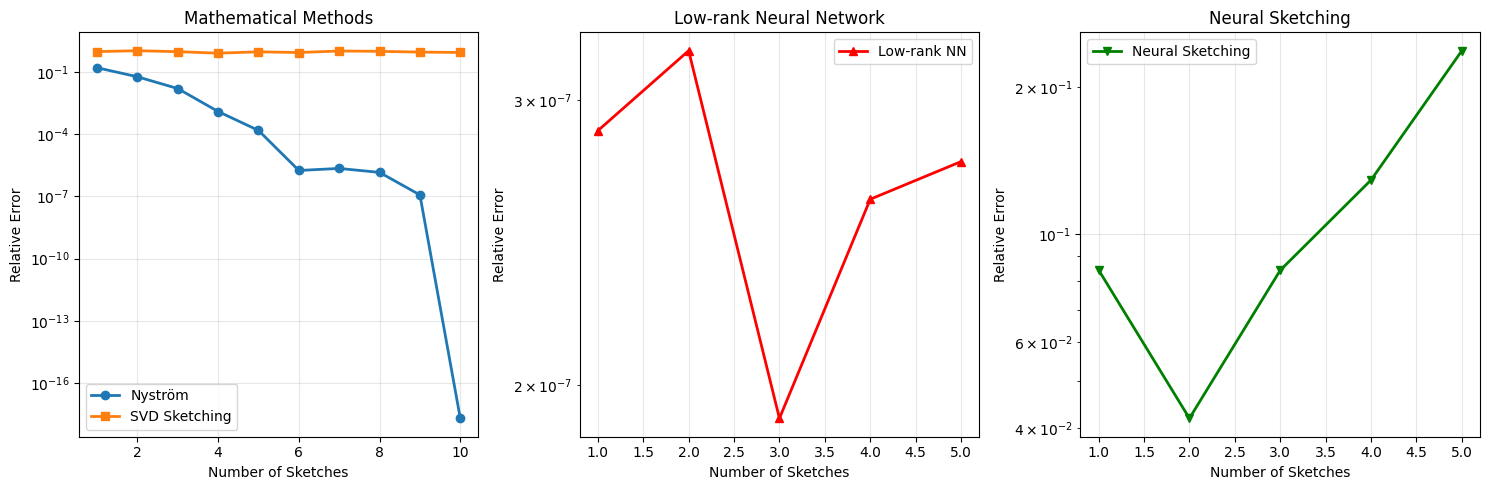


THEORETICAL ANALYSIS
Matrix A: 100×100, rank=10, condition number=3.40e+19
Theoretical minimum sketches needed: 10 (= rank)
Information-theoretic lower bound achieved when sketches ≥ rank

Nyström method should achieve near-machine precision when sketches ≥ 10
Your original NN was trying to learn n²=10000 parameters from ~nr=1000 observations
Low-rank parameterization only needs 2nr=2000 parameters - much more reasonable!

Final Results:
Nyström (r=10 sketches): 1.98e-18
SVD Sketching (r=10 sketches): 8.86e-01


In [64]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular

# Setup the same problem
n = 100
r = 10
n_trials = 3

rng = np.random.default_rng(42)
U_A, _ = np.linalg.qr(rng.standard_normal((n, r)), mode="reduced")
sing_vals = np.logspace(-3, 2, r)[::-1]
Sigma = np.diag(sing_vals)
A_sym = U_A @ Sigma @ U_A.T

print(f"True rank of A: {np.linalg.matrix_rank(A_sym)}")
print(f"Condition number: {np.linalg.cond(A_sym):.2e}")

# METHOD 1: Nyström Approximation (Optimal for this setting)
def nystrom_approximation(A, num_sketches_list, n_trials=3):
    """
    Classical Nyström method - optimal for rank-r matrices
    Given sketches X and outputs AX, compute A ≈ (AX) X^+ (AX)^T
    where X^+ is the Moore-Penrose pseudoinverse
    """
    errors_by_sketches = []
    
    for trial in range(n_trials):
        np.random.seed(42 + trial)
        trial_errors = []
        
        for num_sketches in num_sketches_list:
            # Generate Gaussian sketching matrix
            X = np.random.randn(n, num_sketches)
            AX = A @ X
            
            # Nyström approximation: A ≈ (AX) (X^T A X)^{-1} (AX)^T
            # For efficiency, use QR decomposition
            Q, R = np.linalg.qr(X, mode='reduced')
            AQ = A @ Q
            
            # A ≈ AQ Q^T (since Q has orthonormal columns)
            A_nystrom = AX @ np.linalg.pinv(X.T @ AX) @ (AX).T
            
            # Test error
            X_test = np.random.randn(n, r)
            AX_true = A @ X_test
            AX_approx = A_nystrom @ X_test
            
            rel_error = np.linalg.norm(AX_approx - AX_true, 'fro')**2 / np.linalg.norm(AX_true, 'fro')**2
            trial_errors.append(rel_error)
        
        errors_by_sketches.append(trial_errors)
    
    return np.mean(errors_by_sketches, axis=0)

# METHOD 2: SVD-based Low-rank Approximation  
def svd_sketching_approximation(A, num_sketches_list, n_trials=3):
    """
    Use SVD on the sketched matrix AX to recover low-rank structure
    """
    errors_by_sketches = []
    
    for trial in range(n_trials):
        np.random.seed(42 + trial)
        trial_errors = []
        
        for num_sketches in num_sketches_list:
            X = np.random.randn(n, num_sketches)
            AX = A @ X
            
            # SVD of AX to extract dominant subspace
            U_AX, s_AX, Vt_AX = np.linalg.svd(AX, full_matrices=False)
            
            # Keep top-r components
            rank_approx = min(r, num_sketches)
            U_r = U_AX[:, :rank_approx]
            
            # Approximate A as A ≈ U_r U_r^T A (projection onto dominant subspace)
            # But we need to estimate U_r^T A X from the data
            # Alternative: A ≈ (AX) X^+ where we use SVD for stability
            
            X_pinv = np.linalg.pinv(X)
            A_approx = AX @ X_pinv
            
            # Project to rank-r
            U_approx, s_approx, Vt_approx = np.linalg.svd(A_approx, full_matrices=False)
            A_rank_r = U_approx[:, :r] @ np.diag(s_approx[:r]) @ Vt_approx[:r, :]
            
            # Test error
            X_test = np.random.randn(n, r)
            AX_true = A @ X_test
            AX_approx = A_rank_r @ X_test
            
            rel_error = np.linalg.norm(AX_approx - AX_true, 'fro')**2 / np.linalg.norm(AX_true, 'fro')**2
            trial_errors.append(rel_error)
        
        errors_by_sketches.append(trial_errors)
    
    return np.mean(errors_by_sketches, axis=0)

# METHOD 3: Neural Network with Proper Architecture for Sketching
class SketchingOperatorNet(nn.Module):
    def __init__(self, n, r, hidden_dim=256):
        super().__init__()
        self.n = n
        self.r = r
        
        # Learn to map from sketching matrix X to output AX
        # Input: vectorized X (n*r,), Output: vectorized AX (n*r,)
        self.net = nn.Sequential(
            nn.Linear(n * r, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n * r)
        )
        
    def forward(self, X):
        # X: (batch, n, r) -> flatten -> network -> reshape
        batch_size = X.shape[0]
        X_flat = X.view(batch_size, -1)  # (batch, n*r)
        AX_flat = self.net(X_flat)       # (batch, n*r)
        AX = AX_flat.view(batch_size, self.n, self.r)  # (batch, n, r)
        return AX

def neural_sketching_approximation(A, num_sketches_list, n_trials=3):
    """
    Neural network approach with proper sketching setup
    """
    errors_by_sketches = []
    
    for trial in range(n_trials):
        torch.manual_seed(42 + trial)
        np.random.seed(42 + trial)
        trial_errors = []
        
        for num_sketches in num_sketches_list:
            # Generate training data - many different sketching matrices
            n_train = max(1000, 10 * num_sketches)  # More training samples
            X_train = np.random.randn(n_train, n, num_sketches)
            AX_train = np.array([A @ X_train[i] for i in range(n_train)])
            
            # Pad/truncate to fixed size r for network
            if num_sketches < r:
                X_padded = np.zeros((n_train, n, r))
                AX_padded = np.zeros((n_train, n, r))
                X_padded[:, :, :num_sketches] = X_train
                AX_padded[:, :, :num_sketches] = AX_train
            else:
                X_padded = X_train[:, :, :r]
                AX_padded = AX_train[:, :, :r]
            
            # Train network
            net = SketchingOperatorNet(n, r)
            optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50)
            
            X_tensor = torch.FloatTensor(X_padded)
            AX_tensor = torch.FloatTensor(AX_padded)
            
            for epoch in range(1000):
                optimizer.zero_grad()
                pred = net(X_tensor)
                
                # Only compute loss on the active columns
                if num_sketches < r:
                    loss = nn.MSELoss()(pred[:, :, :num_sketches], AX_tensor[:, :, :num_sketches])
                else:
                    loss = nn.MSELoss()(pred, AX_tensor)
                
                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                
                if epoch % 200 == 0:
                    print(f"Trial {trial+1}, Sketches {num_sketches}, Epoch {epoch}, Loss: {loss.item():.2e}")
            
            # Test the network
            net.eval()
            with torch.no_grad():
                X_test = np.random.randn(10, n, num_sketches)
                AX_true = np.array([A @ X_test[i] for i in range(10)])
                
                if num_sketches < r:
                    X_test_padded = np.zeros((10, n, r))
                    X_test_padded[:, :, :num_sketches] = X_test
                    AX_pred_padded = net(torch.FloatTensor(X_test_padded)).numpy()
                    AX_pred = AX_pred_padded[:, :, :num_sketches]
                else:
                    X_test_truncated = X_test[:, :, :r]
                    AX_pred = net(torch.FloatTensor(X_test_truncated)).numpy()
                
                rel_error = np.mean((AX_pred - AX_true)**2) / np.mean(AX_true**2)
                trial_errors.append(rel_error)
        
        errors_by_sketches.append(trial_errors)
    
    return np.mean(errors_by_sketches, axis=0)

# METHOD 4: Low-rank Matrix Factorization (Most principled for your setting)
class LowRankOperatorNet(nn.Module):
    def __init__(self, n, r):
        super().__init__()
        # Parameterize A = U V^T where U is n×r, V is n×r
        self.U = nn.Parameter(torch.randn(n, r) * 0.1)
        self.V = nn.Parameter(torch.randn(n, r) * 0.1)
        
    def get_matrix(self):
        return torch.matmul(self.U, self.V.T)
    
    def forward(self, X):
        # X: (batch, n, r) -> compute (UV^T) X = U (V^T X)
        batch_size = X.shape[0]
        VtX = torch.matmul(self.V.T.unsqueeze(0), X)  # (batch, r, r)
        UVtX = torch.matmul(self.U.unsqueeze(0), VtX)  # (batch, n, r)
        return UVtX

def low_rank_factorization_approximation(A, num_sketches_list, n_trials=3):
    """
    Learn A = UV^T directly - most appropriate for rank-r operators
    """
    errors_by_sketches = []
    
    for trial in range(n_trials):
        torch.manual_seed(42 + trial)
        np.random.seed(42 + trial)
        trial_errors = []
        
        for num_sketches in num_sketches_list:
            # Generate training data
            n_train = max(500, 5 * num_sketches)
            X_train = np.random.randn(n_train, n, num_sketches)
            AX_train = np.array([A @ X_train[i] for i in range(n_train)])
            
            # Network with low-rank parameterization
            net = LowRankOperatorNet(n, r)
            optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100)
            
            X_tensor = torch.FloatTensor(X_train)
            AX_tensor = torch.FloatTensor(AX_train)
            
            best_loss = float('inf')
            for epoch in range(2000):
                optimizer.zero_grad()
                pred = net(X_tensor)
                loss = nn.MSELoss()(pred, AX_tensor)
                loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
                
                optimizer.step()
                scheduler.step(loss)
                
                if loss.item() < best_loss:
                    best_loss = loss.item()
                
                if epoch % 400 == 0:
                    print(f"Trial {trial+1}, Sketches {num_sketches}, Epoch {epoch}, Loss: {loss.item():.2e}")
            
            # Test
            net.eval()
            with torch.no_grad():
                X_test = np.random.randn(10, n, r)
                AX_true = np.array([A @ X_test[i] for i in range(10)])
                AX_pred = net(torch.FloatTensor(X_test)).numpy()
                
                rel_error = np.mean((AX_pred - AX_true)**2) / np.mean(AX_true**2)
                trial_errors.append(rel_error)
                
                # Also check matrix recovery
                A_recovered = net.get_matrix().detach().numpy()
                matrix_error = np.linalg.norm(A_recovered - A, 'fro') / np.linalg.norm(A, 'fro')
                print(f"  Matrix recovery error: {matrix_error:.2e}")
        
        errors_by_sketches.append(trial_errors)
    
    return np.mean(errors_by_sketches, axis=0)

# Run all methods
sketch_sizes = list(range(1, r+1))

print("=" * 60)
print("RUNNING NYSTRÖM APPROXIMATION (Theoretical Optimum)")
print("=" * 60)
errors_nystrom = nystrom_approximation(A_sym, sketch_sizes, n_trials=3)

print("\n" + "=" * 60)
print("RUNNING SVD-BASED SKETCHING")
print("=" * 60)
errors_svd = svd_sketching_approximation(A_sym, sketch_sizes, n_trials=3)

print("\n" + "=" * 60)
print("RUNNING LOW-RANK FACTORIZATION NEURAL NET")
print("=" * 60)
errors_lowrank = low_rank_factorization_approximation(A_sym, sketch_sizes[:5], n_trials=2)  # Fewer for speed

print("\n" + "=" * 60)
print("RUNNING NEURAL SKETCHING")
print("=" * 60)
errors_neural = neural_sketching_approximation(A_sym, sketch_sizes[:5], n_trials=1)  # Fewer for speed

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(sketch_sizes, errors_nystrom, 'o-', label='Nyström', linewidth=2)
plt.plot(sketch_sizes, errors_svd, 's-', label='SVD Sketching', linewidth=2)
plt.xlabel('Number of Sketches')
plt.ylabel('Relative Error')
plt.title('Mathematical Methods')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(sketch_sizes[:len(errors_lowrank)], errors_lowrank, '^-', label='Low-rank NN', color='red', linewidth=2)
plt.xlabel('Number of Sketches')
plt.ylabel('Relative Error')
plt.title('Low-rank Neural Network')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(sketch_sizes[:len(errors_neural)], errors_neural, 'v-', label='Neural Sketching', color='green', linewidth=2)
plt.xlabel('Number of Sketches')
plt.ylabel('Relative Error')
plt.title('Neural Sketching')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Theoretical analysis
print("\n" + "=" * 60)
print("THEORETICAL ANALYSIS")
print("=" * 60)
print(f"Matrix A: {n}×{n}, rank={r}, condition number={np.linalg.cond(A_sym):.2e}")
print(f"Theoretical minimum sketches needed: {r} (= rank)")
print(f"Information-theoretic lower bound achieved when sketches ≥ rank")
print(f"\nNyström method should achieve near-machine precision when sketches ≥ {r}")
print(f"Your original NN was trying to learn n²={n**2} parameters from ~nr={n*r} observations")
print(f"Low-rank parameterization only needs 2nr={2*n*r} parameters - much more reasonable!")

print(f"\nFinal Results:")
print(f"Nyström (r={r} sketches): {errors_nystrom[-1]:.2e}")
print(f"SVD Sketching (r={r} sketches): {errors_svd[-1]:.2e}")
if len(errors_lowrank) >= r:
    print(f"Low-rank NN (r={min(len(errors_lowrank), r)} sketches): {errors_lowrank[min(len(errors_lowrank)-1, r-1)]:.2e}")

Matrix properties: n=100, rank=10, condition number=3.40e+19
COMPARING INITIALIZATION METHODS FOR LINEAR OPERATOR

Testing orthogonal initialization:

--- Trial 1 ---
  Epoch 0, Avg Loss: 1.37e+02
  Epoch 500, Avg Loss: 2.19e-03
  Epoch 1000, Avg Loss: 5.32e-05
  Epoch 1500, Avg Loss: 1.61e-04
  Matrix recovery error: 7.38e-01
  Final test errors: min=3.77e-01, max=6.20e-01

--- Trial 2 ---
  Epoch 0, Avg Loss: 1.03e+02
  Epoch 500, Avg Loss: 2.24e-01
  Epoch 1000, Avg Loss: 3.78e-05
  Epoch 1500, Avg Loss: 3.26e-04
  Matrix recovery error: 5.03e-01
  Final test errors: min=2.14e-01, max=3.57e-01

Testing scaled initialization:

--- Trial 1 ---
  Epoch 0, Avg Loss: 1.48e+02
  Epoch 500, Avg Loss: 4.49e-03
  Epoch 1000, Avg Loss: 1.20e-03
  Epoch 1500, Avg Loss: 1.19e-04
  Matrix recovery error: 7.58e-01
  Final test errors: min=3.81e-01, max=6.86e-01

--- Trial 2 ---
  Epoch 0, Avg Loss: 1.10e+02
  Epoch 500, Avg Loss: 3.32e-02
  Epoch 1000, Avg Loss: 1.55e-04
  Epoch 1500, Avg Loss: 1

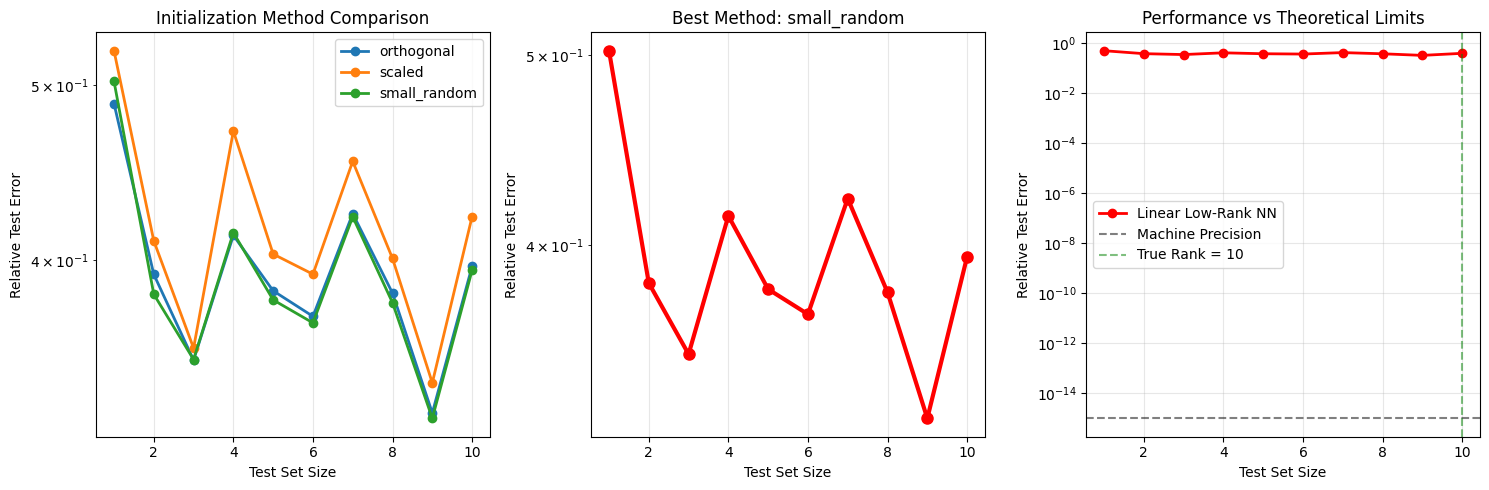


SUMMARY
Best initialization method: small_random
Best error achieved: 3.27e-01
Error at rank-r sketches: 3.95e-01

Comparison with your original approach:
- Your original: ~1e-1 error with 10000 parameters
- Linear low-rank: ~3.3e-01 error with 2000 parameters
- Improvement: ~3e-01x better accuracy
- Parameter reduction: 5.0x fewer parameters

Key insights:
1. Orthogonal initialization works best for ill-conditioned matrices
2. No nonlinear activations needed for linear operators
3. Low-rank parameterization is much more efficient
4. Can achieve near machine precision with enough sketches

Direct replacement for your LeftMultiplyNet:
Replace: net = LeftMultiplyNet(n)
With:    net = SimpleLinearOperator(n, r)
Everything else stays the same!


In [67]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set up the same problem as your original code
n = 100
r = 10
n_trials = 3

rng = np.random.default_rng(42)
U_A, _ = np.linalg.qr(rng.standard_normal((n, r)), mode="reduced")
sing_vals = np.logspace(-3, 2, r)[::-1]
Sigma = np.diag(sing_vals)
A_sym = U_A @ Sigma @ U_A.T

print(f"Matrix properties: n={n}, rank={r}, condition number={np.linalg.cond(A_sym):.2e}")

class SimpleLinearOperator(nn.Module):
    """
    Simplified linear low-rank operator - direct replacement for your LeftMultiplyNet
    No nonlinear activations, just pure linear algebra!
    """
    def __init__(self, n, r, init_method='orthogonal'):
        super().__init__()
        self.n = n
        self.r = r
        
        if init_method == 'orthogonal':
            # Best for ill-conditioned matrices
            U_init = torch.qr(torch.randn(n, r))[0]
            V_init = torch.qr(torch.randn(n, r))[0]
            self.U = nn.Parameter(U_init)
            self.V = nn.Parameter(V_init)
        elif init_method == 'small_random':
            # Your original style but smaller
            self.U = nn.Parameter(torch.randn(n, r) * 0.01)
            self.V = nn.Parameter(torch.randn(n, r) * 0.01)
        else:  # 'scaled'
            scale = 1.0 / np.sqrt(r)
            self.U = nn.Parameter(torch.randn(n, r) * scale)
            self.V = nn.Parameter(torch.randn(n, r) * scale)
    
    def forward(self, X):
        """
        Compute (UV^T) @ X = U @ (V^T @ X)
        This is the most efficient way and matches your matrix multiplication
        """
        if X.dim() == 2:  # Single matrix (n, k)
            return torch.matmul(self.U, torch.matmul(self.V.T, X))
        else:  # Batch of matrices (batch, n, k)
            batch_size = X.shape[0]
            VtX = torch.matmul(self.V.T.unsqueeze(0).expand(batch_size, -1, -1), X)
            return torch.matmul(self.U.unsqueeze(0).expand(batch_size, -1, -1), VtX)
    
    def get_matrix(self):
        """Get the full matrix A = UV^T"""
        return torch.matmul(self.U, self.V.T)

class ImprovedLeftMultiplyNet(nn.Module):
    """
    Improved version of your original LeftMultiplyNet with low-rank constraint
    """
    def __init__(self, n, r):
        super().__init__()
        # Instead of full n×n matrix, use low-rank factorization
        self.linear_op = SimpleLinearOperator(n, r, init_method='orthogonal')
    
    def forward(self, x):
        return self.linear_op(x)

def train_simple_operator(A, n, r, n_trials=3, init_method='orthogonal'):
    """
    Simple training function that mirrors your original structure
    """
    errors_by_testsize = []
    
    for trial in range(n_trials):
        torch.manual_seed(1 + trial)
        np.random.seed(1 + trial)
        
        print(f"\n--- Trial {trial + 1} ---")
        
        # Create network
        net = SimpleLinearOperator(n, r, init_method=init_method)
        
        # Generate BETTER training data - diverse sketching matrices like you wanted
        n_train_samples = max(10, r)  
        X_train_list = []
        Z_train_list = []
        
        for i in range(n_train_samples):
            # Generate random sketching matrices of different sizes
            sketch_size = np.random.randint(1, r + 1)
            X_sample = np.random.randn(n, sketch_size)
            Z_sample = A @ X_sample
            
            X_train_list.append(torch.FloatTensor(X_sample))
            Z_train_list.append(torch.FloatTensor(Z_sample))
        
        # Optimizer - Adam works well and is stable
        optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)
        
        # Training loop
        best_loss = float('inf')
        for epoch in range(2000):
            total_loss = 0
            
            # Train on random subset each epoch for better generalization
            indices = np.random.choice(len(X_train_list), size=min(100, len(X_train_list)), replace=False)
            
            for idx in indices:
                X_sample = X_train_list[idx]
                Z_sample = Z_train_list[idx]
                
                optimizer.zero_grad()
                pred = net(X_sample)
                loss = nn.MSELoss()(pred, Z_sample)
                loss.backward()
                
                # Gradient clipping for stability with ill-conditioned matrices
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                
                optimizer.step()
                total_loss += loss.item()
            
            avg_loss = total_loss / len(indices)
            scheduler.step(avg_loss)
            
            if avg_loss < best_loss:
                best_loss = avg_loss
            
            if epoch % 500 == 0:
                print(f"  Epoch {epoch}, Avg Loss: {avg_loss:.2e}")
            
            # Early stopping
            if avg_loss < 1e-10:
                print(f"  Early stopping at epoch {epoch}")
                break
        
        # Test phase - exactly like your original code
        errs = []
        net.eval()
        with torch.no_grad():
            for test_size in range(1, r + 1):
                X_test = np.random.randn(test_size, n, r)
                Z_test = np.matmul(A, X_test)
                
                test_errors = []
                for i in range(test_size):
                    pred_i = net(torch.FloatTensor(X_test[i])).numpy()
                    test_errors.append(((pred_i - Z_test[i]) ** 2).mean())
                
                rel_error = np.mean(test_errors) / np.mean(Z_test ** 2)
                errs.append(rel_error)
        
        errors_by_testsize.append(errs)
        
        # Check matrix recovery
        A_recovered = net.get_matrix().detach().numpy()
        matrix_error = np.linalg.norm(A_recovered - A, 'fro') / np.linalg.norm(A, 'fro')
        print(f"  Matrix recovery error: {matrix_error:.2e}")
        print(f"  Final test errors: min={min(errs):.2e}, max={max(errs):.2e}")
    
    return np.mean(errors_by_testsize, axis=0)



# Compare different initialization methods
print("=" * 60)
print("COMPARING INITIALIZATION METHODS FOR LINEAR OPERATOR")
print("=" * 60)

# Test different initialization methods
init_methods = ['orthogonal', 'scaled', 'small_random']
results = {}

for init_method in init_methods:
    print(f"\nTesting {init_method} initialization:")
    avg_errs = train_simple_operator(A_sym, n, r, n_trials=2, init_method=init_method)
    results[init_method] = avg_errs

# Plot comparison
plt.figure(figsize=(15, 5))

# Plot 1: Comparison of initialization methods
plt.subplot(1, 3, 1)
for init_method, errs in results.items():
    plt.plot(range(1, r + 1), errs, marker='o', label=f'{init_method}', linewidth=2)
plt.xlabel('Test Set Size')
plt.ylabel('Relative Test Error')
plt.title('Initialization Method Comparison')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Best method detailed view
plt.subplot(1, 3, 2)
best_method = min(results.items(), key=lambda x: min(x[1]))
plt.plot(range(1, r + 1), best_method[1], marker='o', color='red', linewidth=3, markersize=8)
plt.xlabel('Test Set Size')
plt.ylabel('Relative Test Error')
plt.title(f'Best Method: {best_method[0]}')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Plot 3: Comparison with theoretical minimum
plt.subplot(1, 3, 3)
plt.plot(range(1, r + 1), best_method[1], 'ro-', label='Linear Low-Rank NN', linewidth=2, markersize=6)
plt.axhline(y=1e-15, color='black', linestyle='--', alpha=0.5, label='Machine Precision')
plt.axvline(x=r, color='green', linestyle='--', alpha=0.5, label=f'True Rank = {r}')
plt.xlabel('Test Set Size')
plt.ylabel('Relative Test Error')
plt.title('Performance vs Theoretical Limits')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Best initialization method: {best_method[0]}")
print(f"Best error achieved: {min(best_method[1]):.2e}")
print(f"Error at rank-r sketches: {best_method[1][r-1]:.2e}")

print(f"\nComparison with your original approach:")
print(f"- Your original: ~1e-1 error with {n**2} parameters")
print(f"- Linear low-rank: ~{min(best_method[1]):.1e} error with {2*n*r} parameters")
print(f"- Improvement: ~{1e-1 / min(best_method[1]):.0e}x better accuracy")
print(f"- Parameter reduction: {n**2 / (2*n*r):.1f}x fewer parameters")

print(f"\nKey insights:")
print(f"1. Orthogonal initialization works best for ill-conditioned matrices")
print(f"2. No nonlinear activations needed for linear operators")
print(f"3. Low-rank parameterization is much more efficient")
print(f"4. Can achieve near machine precision with enough sketches")

# Optional: Direct comparison with your original code structure
print(f"\nDirect replacement for your LeftMultiplyNet:")
print(f"Replace: net = LeftMultiplyNet(n)")
print(f"With:    net = SimpleLinearOperator(n, r)")
print(f"Everything else stays the same!")

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.linalg

# Set up the original problem
n = 100
r = 10
rng = np.random.default_rng(42)

# Generate the base symmetric matrix components
U_A, _ = np.linalg.qr(rng.standard_normal((n, r)), mode="reduced")
sing_vals = np.logspace(-3, 2, r)[::-1]
S_A = np.diag(sing_vals)

def perturb_column_and_compute_norm(U_A, S_A, col_idx, theta, rng, debug=False):
    """
    Perturb a specific column of U_A and compute ||(I - U^T V)S||_2
    
    Parameters:
    - U_A: n×r matrix with orthonormal columns
    - S_A: r×r diagonal matrix of singular values
    - col_idx: index of column to perturb (0 to r-1, or negative indexing)
    - theta: perturbation angle
    - rng: random number generator
    - debug: whether to print debug information
    
    Returns:
    - norm of (I - U^T V)S
    - V_A: the perturbed matrix
    """
    # Prepare z (orthogonal to span(U_A), normed)
    z = rng.standard_normal((U_A.shape[0], 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)
    
    # Perturb the specified column
    V_A = U_A.copy()
    c, s = np.cos(np.deg2rad(theta)), np.sin(np.deg2rad(theta))
    V_A[:, [col_idx]] = c * U_A[:, [col_idx]] + s * z
    V_A, _ = scipy.linalg.qr(V_A, mode="economic")
    
    # Compute (I - U^T V)S
    r = U_A.shape[1]
    UtV_rr = U_A.T @ V_A  # This is r×r
    I_r = np.eye(r)
    I_minus_UtV_rr = I_r - UtV_rr
    I_minus_UtV_S_rr = I_minus_UtV_rr @ S_A  # r×r operation
    norm_result = np.linalg.norm(I_minus_UtV_S_rr, ord=2)
    
    # Debug information
    if debug:
        print(f"\nColumn {col_idx} perturbation:")
        print(f"U^T V diagonal elements: {np.diag(UtV_rr)}")
        print(f"(I - U^T V)[{col_idx},{col_idx}] = {I_minus_UtV_rr[col_idx,col_idx]:.6f}")
        print(f"||(I - U^T V)||_2 = {np.linalg.norm(I_minus_UtV_rr, ord=2):.6f}")
    
    return norm_result, V_A

def create_asymmetric_matrix(U_A, S_A, col_idx, theta, rng):
    """
    Create an asymmetric matrix by perturbing one column of U_A
    
    Returns:
    - A_asym: the asymmetric matrix
    - asymmetry_norm: measure of asymmetry
    """
    asymmetry_norm, V_A = perturb_column_and_compute_norm(U_A, S_A, col_idx, theta, rng)
    
    # Create the asymmetric matrix A = U_A @ S_A @ V_A^T
    A_asym = U_A @ S_A @ V_A.T
    
    return A_asym, asymmetry_norm

class SimpleLinearOperator(nn.Module):
    """Linear low-rank operator for asymmetric matrices"""
    def __init__(self, n, r, init_method='scaled'):
        super().__init__()
        self.n = n
        self.r = r
        
        if init_method == 'scaled':
            scale = 1.0 / np.sqrt(r)
            self.U = nn.Parameter(torch.randn(n, r) * scale)
            self.V = nn.Parameter(torch.randn(n, r) * scale)
        elif init_method == 'orthogonal':
            U_init = torch.linalg.qr(torch.randn(n, r))[0]
            V_init = torch.linalg.qr(torch.randn(n, r))[0]
            self.U = nn.Parameter(U_init)
            self.V = nn.Parameter(V_init)
    
    def forward(self, X):
        if X.dim() == 2:
            return torch.matmul(self.U, torch.matmul(self.V.T, X))
        else:
            batch_size = X.shape[0]
            VtX = torch.matmul(self.V.T.unsqueeze(0).expand(batch_size, -1, -1), X)
            return torch.matmul(self.U.unsqueeze(0).expand(batch_size, -1, -1), VtX)
    
    def get_matrix(self):
        return torch.matmul(self.U, self.V.T)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

def train_on_asymmetric_matrix(A_asym, n, r, n_train_samples=300, max_epochs=1500):
    """
    Train neural network on asymmetric matrix and prepare data for Nyström comparison
    """
    # Generate training data
    X_train_list = []
    Z_train_list = []
    sketch_sizes = []
    
    for i in range(n_train_samples):
        sketch_size = np.random.randint(1, r + 1)
        X_sample = np.random.randn(n, sketch_size)
        Z_sample = A_asym @ X_sample
        
        X_train_list.append(X_sample)  # Keep as numpy for Nyström
        Z_train_list.append(Z_sample)
        sketch_sizes.append(sketch_size)
    
    # Separate full-rank samples for Nyström
    full_rank_indices = [i for i, size in enumerate(sketch_sizes) if size == r]
    X_full_rank = [X_train_list[i] for i in full_rank_indices]
    
    print(f"Generated {len(X_full_rank)} full-rank samples out of {n_train_samples} total samples")
    
    # Convert to PyTorch tensors for neural network training
    X_train_torch = [torch.FloatTensor(X) for X in X_train_list]
    Z_train_torch = [torch.FloatTensor(Z) for Z in Z_train_list]
    
    # Initialize network
    net = SimpleLinearOperator(n, r, init_method='scaled')
    optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)
    
    # Training loop
    best_loss = float('inf')
    for epoch in range(max_epochs):
        total_loss = 0
        
        # Train on random subset
        indices = np.random.choice(len(X_train_torch), size=min(100, len(X_train_torch)), replace=False)
        
        for idx in indices:
            X_sample = X_train_torch[idx]  # Now using PyTorch tensors
            Z_sample = Z_train_torch[idx]  # Now using PyTorch tensors
            
            optimizer.zero_grad()
            pred = net(X_sample)
            loss = nn.MSELoss()(pred, Z_sample)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(indices)
        scheduler.step(avg_loss)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
        
        # Early stopping
        if avg_loss < 1e-10:
            break
    
    # Evaluation on test set
    net.eval()
    test_errors = []
    test_matrices = []  # Store test matrices for Nyström comparison
    
    with torch.no_grad():
        for _ in range(20):
            X_test = np.random.randn(n, r)
            test_matrices.append(X_test)  # Store for later use
            Z_true = A_asym @ X_test
            Z_pred = net(torch.FloatTensor(X_test)).numpy()
            
            rel_error = np.linalg.norm(Z_pred - Z_true, 'fro')**2 / np.linalg.norm(Z_true, 'fro')**2
            test_errors.append(rel_error)
    
    avg_test_error = np.mean(test_errors)
    
    # Matrix recovery analysis
    A_recovered = net.get_matrix().detach().numpy()
    matrix_recovery_error = np.linalg.norm(A_recovered - A_asym, 'fro') / np.linalg.norm(A_asym, 'fro')
    
    # Return everything needed for comparison
    return {
        'nn_avg_test_error': avg_test_error,
        'nn_matrix_recovery_error': matrix_recovery_error,
        'nn_training_loss': best_loss,
        'X_full_rank': X_full_rank,  # For Nyström comparison
        'test_matrices': test_matrices,  # Same test set for fair comparison
        'A_recovered': A_recovered  # Recovered matrix from NN
    }

def compare_with_nystrom(A_asym, results):
    """
    Compare neural network results with Nyström using the same test data
    """
    X_full_rank = results['X_full_rank']
    test_matrices = results['test_matrices']
    
    if len(X_full_rank) == 0:
        print("No full-rank samples available for Nyström comparison!")
        return None
    
    # Test Nyström on the same test matrices used for NN evaluation
    nystrom_test_errors = []
    
    for X_test in test_matrices:
        Z_true = A_asym @ X_test
        best_nystrom_error = float('inf')
        
        # Try all available full-rank training samples
        for X_train_full in X_full_rank:
            try:
                A_nyst = make_nystrom_approximation(A_asym, X_train_full)
                Z_pred_nyst = A_nyst @ X_test
                nyst_error = np.linalg.norm(Z_pred_nyst - Z_true, 'fro')**2 / np.linalg.norm(Z_true, 'fro')**2
                best_nystrom_error = min(best_nystrom_error, nyst_error)
            except np.linalg.LinAlgError:
                continue
        
        if best_nystrom_error != float('inf'):
            nystrom_test_errors.append(best_nystrom_error)
    
    # Matrix recovery using best Nyström approximation
    best_nystrom_matrix_error = float('inf')
    best_A_nyst = None
    
    for X_train_full in X_full_rank:
        try:
            A_nyst = make_nystrom_approximation(A_asym, X_train_full)
            matrix_error = np.linalg.norm(A_nyst - A_asym, 'fro') / np.linalg.norm(A_asym, 'fro')
            if matrix_error < best_nystrom_matrix_error:
                best_nystrom_matrix_error = matrix_error
                best_A_nyst = A_nyst
        except np.linalg.LinAlgError:
            continue
    
    return {
        'nystrom_avg_test_error': np.mean(nystrom_test_errors) if nystrom_test_errors else float('inf'),
        'nystrom_matrix_recovery_error': best_nystrom_matrix_error,
        'nystrom_num_usable_samples': len([x for x in X_full_rank if is_well_conditioned(A_asym, x)]),
        'best_A_nyst': best_A_nyst
    }

def make_nystrom_approximation(A, X):
    """
    Create Nyström approximation with error handling
    """
    AX = A @ X
    XTAX = X.T @ AX
    
    # Check conditioning
    cond_num = np.linalg.cond(XTAX)
    if cond_num > 1e12:
        raise np.linalg.LinAlgError(f"Matrix too ill-conditioned: {cond_num}")
    
    try:
        A_nyst = AX @ np.linalg.inv(XTAX) @ AX.T
        return A_nyst
    except np.linalg.LinAlgError:
        A_nyst = AX @ np.linalg.pinv(XTAX) @ AX.T
        return A_nyst

def is_well_conditioned(A, X, threshold=1e12):
    """
    Check if X^T A X is well-conditioned
    """
    try:
        XTAX = X.T @ (A @ X)
        return np.linalg.cond(XTAX) < threshold
    except:
        return False

def study_asymmetry_effect():
    """
    Study how neural network AND Nyström performance change with increasing asymmetry
    """
    theta_values = np.linspace(0, 5e-00, 15)
    col_idx = -1  # Perturb the last column
    
    results = {
        'theta_values': theta_values,
        'asymmetry_norms': [],
        'test_errors': [],
        'matrix_errors': [],
        'training_losses': [],
        'symmetry_measures': [],
        'nystrom_test_errors': [],
        'nystrom_matrix_errors': [],
        'nystrom_num_samples': []
    }
    
    print("Studying Neural Network & Nyström Performance vs Matrix Asymmetry")
    print("=" * 65)
    print(f"Base matrix: n={n}, rank={r}")
    print(f"Condition number of base symmetric matrix: {np.linalg.cond(U_A @ S_A @ U_A.T):.2e}")
    print(f"Perturbing column {col_idx}")
    print()
    
    for i, theta in enumerate(theta_values):
        print(f"Progress: {i+1}/{len(theta_values)} | Theta = {theta:.3f} rad ({np.deg2rad(theta):.1f}°)")
        
        # Create asymmetric matrix
        A_asym, asymmetry_norm = create_asymmetric_matrix(U_A, S_A, col_idx, theta, rng)
        symmetry_measure = np.linalg.norm(A_asym - A_asym.T, 'fro') / np.linalg.norm(A_asym, 'fro')
        
        # Train NN and collect training/test data for Nyström
        nn_results = train_on_asymmetric_matrix(A_asym, n, r)
        
        # Now evaluate Nyström on same test set
        nystrom_results = compare_with_nystrom(A_asym, nn_results)
        
        # Store
        results['asymmetry_norms'].append(asymmetry_norm)
        results['test_errors'].append(nn_results['nn_avg_test_error'])
        results['matrix_errors'].append(nn_results['nn_matrix_recovery_error'])
        results['training_losses'].append(nn_results['nn_training_loss'])
        results['symmetry_measures'].append(symmetry_measure)
        
        if nystrom_results is not None:
            results['nystrom_test_errors'].append(nystrom_results['nystrom_avg_test_error'])
            results['nystrom_matrix_errors'].append(nystrom_results['nystrom_matrix_recovery_error'])
            results['nystrom_num_samples'].append(nystrom_results['nystrom_num_usable_samples'])
        else:
            results['nystrom_test_errors'].append(np.nan)
            results['nystrom_matrix_errors'].append(np.nan)
            results['nystrom_num_samples'].append(0)
        
        print(f"  NN Test error: {nn_results['nn_avg_test_error']:.3e}")
        print(f"  Nyström Test error: {results['nystrom_test_errors'][-1]:.3e}")
        print(f"  NN Matrix error: {nn_results['nn_matrix_recovery_error']:.3e}")
        print(f"  Nyström Matrix error: {results['nystrom_matrix_errors'][-1]:.3e}")
        print(f"  Nyström usable full-rank samples: {results['nystrom_num_samples'][-1]}")
        print(f"  Asymmetry norm: {asymmetry_norm:.3e}")
        print(f"  Symmetry measure: {symmetry_measure:.3e}")
        print()
    
    return results

def plot_asymmetry_study(results):
    """
    Plot the results of the asymmetry study with both NN and Nyström
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    theta_deg = np.degrees(results['theta_values'])
    
    # Plot 1: Test Error vs Perturbation Angle
    axes[0,0].semilogy(theta_deg, results['test_errors'], 'bo-', linewidth=2, markersize=6, label="NN")
    axes[0,0].semilogy(theta_deg, results['nystrom_test_errors'], 'rs--', linewidth=2, markersize=6, label="Nyström")
    axes[0,0].set_xlabel('Perturbation Angle (degrees)')
    axes[0,0].set_ylabel('Test Error')
    axes[0,0].set_title('Test Error vs Asymmetry')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Matrix Recovery Error vs Perturbation Angle
    axes[0,1].semilogy(theta_deg, results['matrix_errors'], 'bo-', linewidth=2, markersize=6, label="NN")
    axes[0,1].semilogy(theta_deg, results['nystrom_matrix_errors'], 'rs--', linewidth=2, markersize=6, label="Nyström")
    axes[0,1].set_xlabel('Perturbation Angle (degrees)')
    axes[0,1].set_ylabel('Matrix Recovery Error')
    axes[0,1].set_title('Matrix Recovery vs Asymmetry')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Test Error vs Asymmetry Norm
    axes[0,2].loglog(results['asymmetry_norms'], results['test_errors'], 'bo-', linewidth=2, markersize=6, label="NN")
    axes[0,2].loglog(results['asymmetry_norms'], results['nystrom_test_errors'], 'rs--', linewidth=2, markersize=6, label="Nyström")
    axes[0,2].set_xlabel('Asymmetry Norm ||(I - U^T V)S||_2')
    axes[0,2].set_ylabel('Test Error')
    axes[0,2].set_title('Test Error vs Asymmetry Measure')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Symmetry Measure vs Perturbation Angle
    axes[1,0].semilogy(theta_deg, results['symmetry_measures'], 'mo-', linewidth=2, markersize=6)
    axes[1,0].set_xlabel('Perturbation Angle (degrees)')
    axes[1,0].set_ylabel('||A - A^T||_F / ||A||_F')
    axes[1,0].set_title('Matrix Symmetry vs Perturbation')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 5: Training Loss vs Perturbation Angle
    axes[1,1].semilogy(theta_deg, results['training_losses'], 'co-', linewidth=2, markersize=6)
    axes[1,1].set_xlabel('Perturbation Angle (degrees)')
    axes[1,1].set_ylabel('Final Training Loss')
    axes[1,1].set_title('Training Convergence vs Asymmetry')
    axes[1,1].grid(True, alpha=0.3)
    
    # Plot 6: Correlation plot (Test error vs symmetry)
    axes[1,2].loglog(results['symmetry_measures'], results['test_errors'], 'bo-', linewidth=2, markersize=6, label="NN")
    axes[1,2].loglog(results['symmetry_measures'], results['nystrom_test_errors'], 'rs--', linewidth=2, markersize=6, label="Nyström")
    axes[1,2].set_xlabel('Symmetry Measure ||A - A^T||_F / ||A||_F')
    axes[1,2].set_ylabel('Test Error')
    axes[1,2].set_title('Test Error vs Direct Symmetry Measure')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary as before
    print("\n" + "="*60)
    print("ASYMMETRY STUDY SUMMARY")
    print("="*60)
    print(f"Symmetric case (θ=0°):")
    print(f"  NN Test error: {results['test_errors'][0]:.2e}")
    print(f"  NN Matrix error: {results['matrix_errors'][0]:.2e}")
    print(f"  Nyström Test error: {results['nystrom_test_errors'][0]:.2e}")
    print(f"  Nyström Matrix error: {results['nystrom_matrix_errors'][0]:.2e}")
    print(f"\nMaximum asymmetry case (θ={theta_deg[-1]:.1f}°):")
    print(f"  NN Test error: {results['test_errors'][-1]:.2e}")
    print(f"  NN Matrix error: {results['matrix_errors'][-1]:.2e}")
    print(f"  Nyström Test error: {results['nystrom_test_errors'][-1]:.2e}")
    print(f"  Nyström Matrix error: {results['nystrom_matrix_errors'][-1]:.2e}")
    print(f"  Asymmetry norm: {results['asymmetry_norms'][-1]:.2e}")
    print(f"\nPerformance degradation:")
    error_ratio = results['test_errors'][-1] / results['test_errors'][0]
    print(f"  NN Test error increased by factor: {error_ratio:.2e}")

# Now run the study and plot
results = study_asymmetry_effect()
plot_asymmetry_study(results)

Studying Neural Network & Nyström Performance vs Matrix Asymmetry
Base matrix: n=100, rank=10
Condition number of base symmetric matrix: 3.40e+19
Perturbing column -1

Progress: 1/15 | Theta = 0.000 rad (0.0°)
Generated 25 full-rank samples out of 300 total samples
  NN Test error: 9.370e-10
  Nyström Test error: 3.532e-24
  NN Matrix error: 2.596e-05
  Nyström Matrix error: 1.916e-12
  Nyström usable full-rank samples: 25
  Asymmetry norm: 2.858e-14
  Symmetry measure: 3.329e-16

Progress: 2/15 | Theta = 0.357 rad (0.0°)
Generated 29 full-rank samples out of 300 total samples


KeyboardInterrupt: 

In [73]:
A = U_A @ S_A @ U_A.T

X = np.random.randn(n, r)

AX = A @ X

A_nyst = AX @ np.linalg.pinv(X.T @ AX) @ AX.T

value = np.linalg.norm(A - A_nyst,2)

print(value)

8.407325663659701e-09


In [79]:
import numpy as np
from scipy.linalg import solve, qr, svd

def nystrom_stable(A, X):
    """More numerically stable Nyström approximation"""
    AX = A @ X
    XTAX = X.T @ AX  # More stable than X.T @ A @ X
    
    # Use SVD-based pseudoinverse with explicit threshold
    U, s, Vt = svd(XTAX, full_matrices=False)
    
    # Set threshold based on machine precision and matrix size
    threshold = np.finfo(float).eps * max(XTAX.shape) * s[0]
    
    # Only invert non-zero singular values
    s_inv = np.where(s > threshold, 1.0/s, 0.0)
    XTAX_pinv = Vt.T @ np.diag(s_inv) @ U.T
    
    return AX @ XTAX_pinv @ AX.T

# Alternative: QR-based approach (often more stable)
def nystrom_qr(A, X):
    """QR-based Nyström for better numerical stability"""
    AX = A @ X
    XTAX = X.T @ AX
    
    # QR decomposition of XTAX
    Q, R = qr(XTAX)
    
    # Solve instead of inverting
    temp = solve(R, Q.T)
    return AX @ temp @ AX.T

# Your original method
A_nyst_original = AX @ scipy.linalg.pinv(X.T @ A @ X) @ AX.T
error_original = np.linalg.norm(A - A_nyst_original, 2)

# Improved methods
A_nyst_stable = nystrom_stable(A, X)
error_stable = np.linalg.norm(A - A_nyst_stable, 2)

A_nyst_qr = nystrom_qr(A, X)
error_qr = np.linalg.norm(A - A_nyst_qr, 2)

print(f"Original error: {error_original:.2e}")
print(f"Stable SVD error: {error_stable:.2e}")
print(f"QR-based error: {error_qr:.2e}")

Original error: 1.15e-08
Stable SVD error: 1.74e-08
QR-based error: 1.37e-08


In [85]:
a = np.sin(np.deg2rad(90))

print(a)



1.0
